In [1]:
import pandas as pd
import inflection as ifn
from IPython.display import display
from IPython.display import Image
import numpy as np
import math
import seaborn as sns
from matplotlib import pyplot as plt
import datetime

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x :'%5f' %x)

In [2]:
data = pd.read_csv('Data/predictionStoreP03.csv', parse_dates=['date','year_week','competition_since','promo_since'])
data.loc[data.competition_distance == data['competition_distance'].max(), 'competition_distance'] = 100000


### 3.0. Filtragem de variáveis

#### 3.1. Filtragem das linhas

In [3]:
df = data.loc[data['open'] != 0 & (data['sales'] > 0)]    

#### 3.0. Filtragem das colunas

In [4]:
df = df.drop(['customers','open','promo_interval', 'month_map'], axis=1)

### 4.0. Análise exploratória dos dados

In [5]:
sns.set(rc={'figure.figsize':(28,10)})

#### 4.1. Análise Univariada

##### 4.1.1 Análise isolda da target

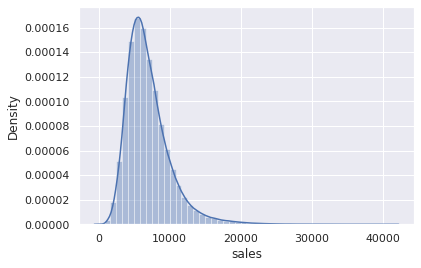

In [6]:
ax = sns.distplot(df.sales)

##### 4.1.2 Análise de variáveis numéricas

In [7]:
num_atrib = df.select_dtypes(['int64','float64'])

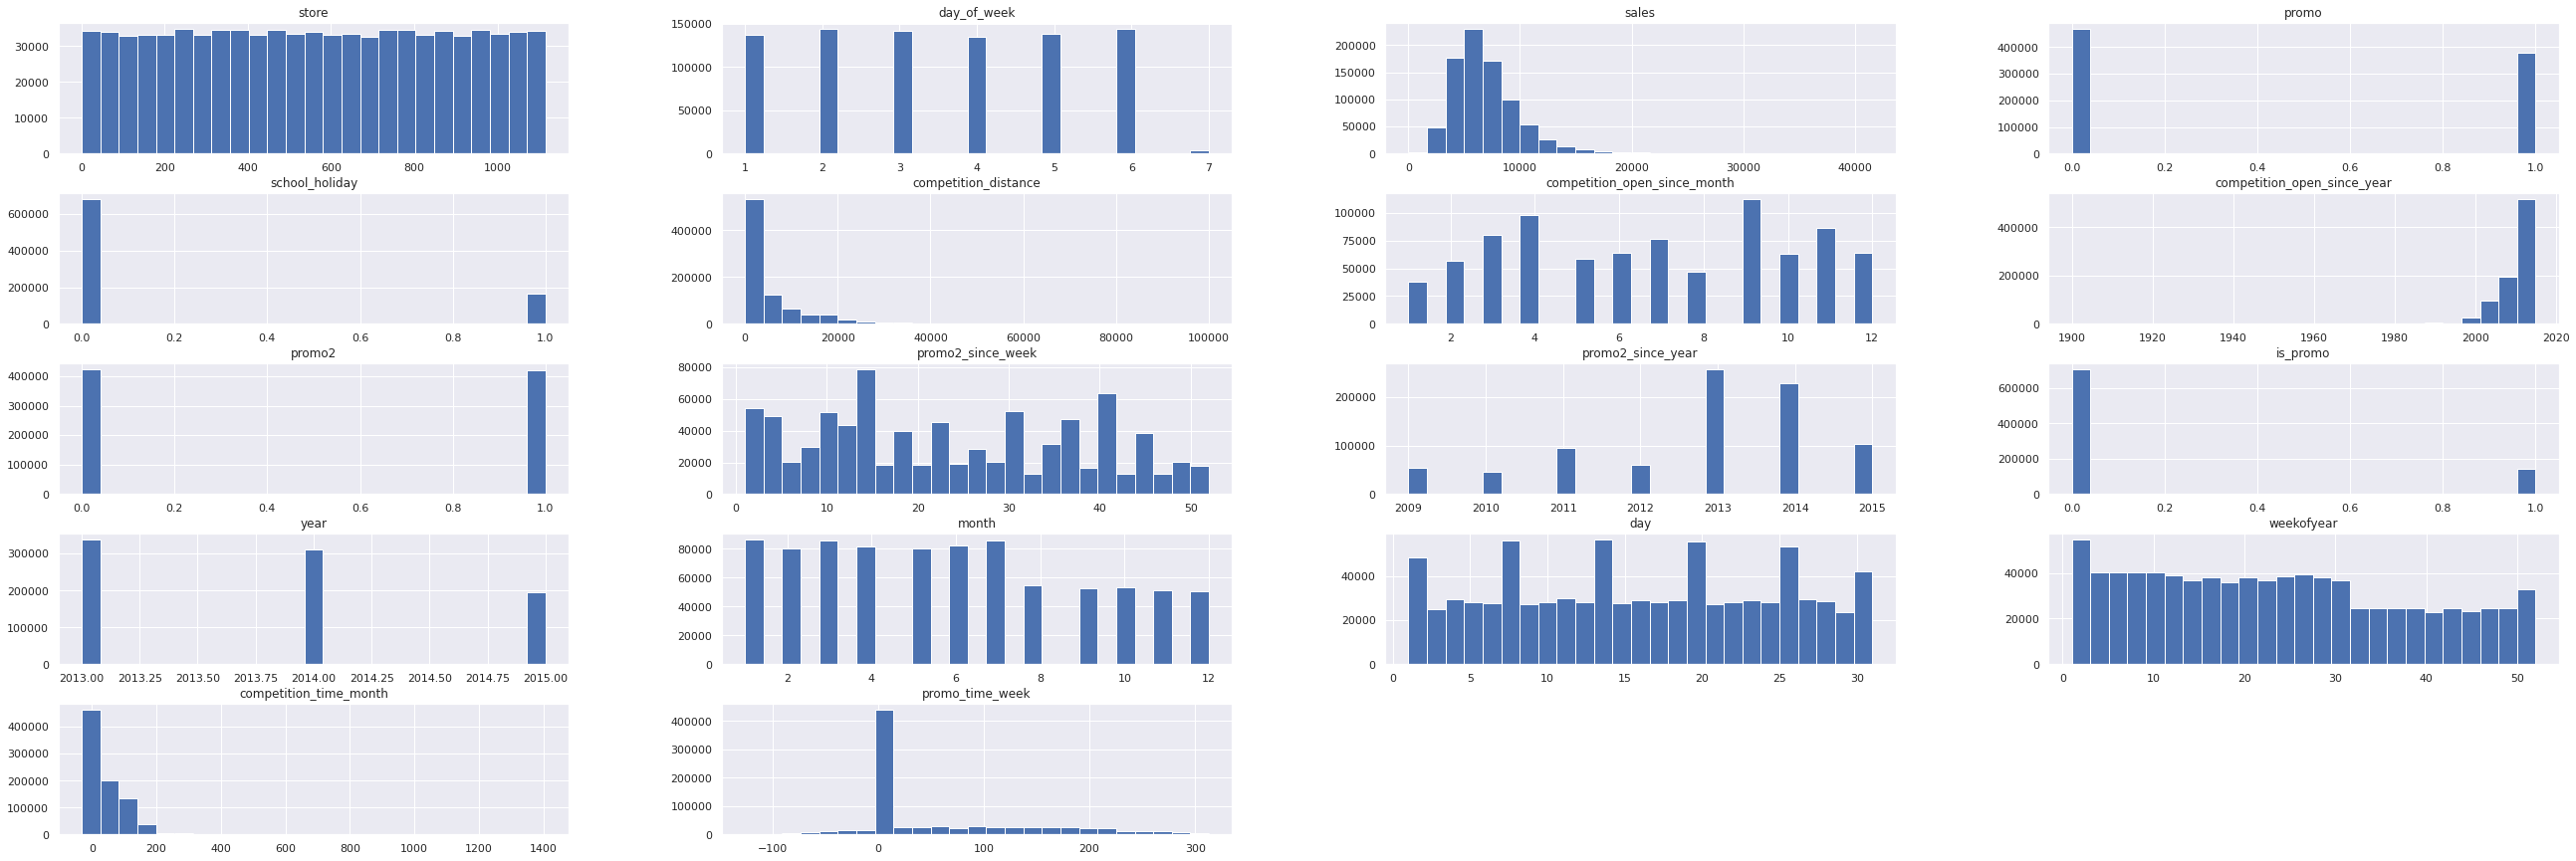

In [8]:
num_atrib.hist(figsize=(45,15), bins=25);

In [9]:
num_atrib = df.select_dtypes(['int64','float64'])

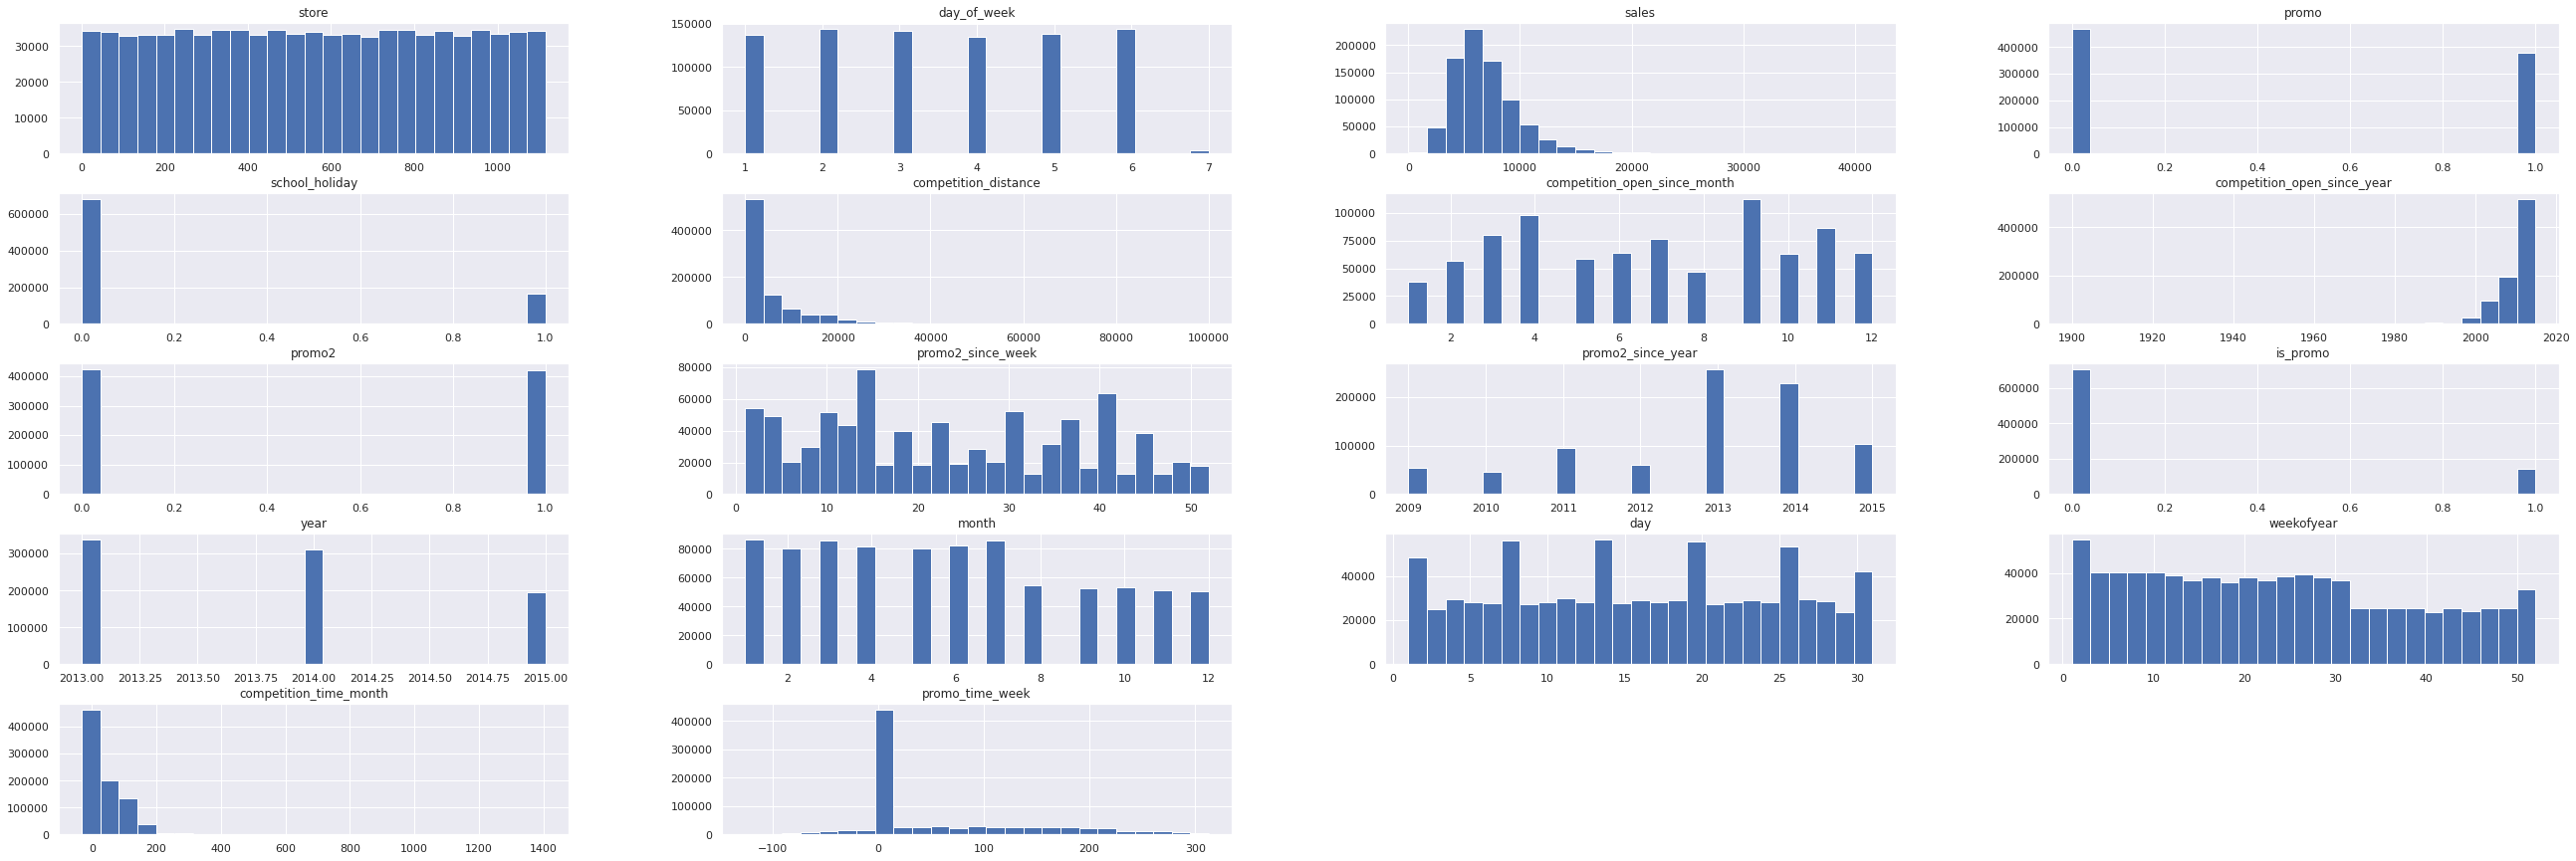

In [10]:
num_atrib.hist(figsize=(45,15), bins=25);

##### 4.1.3 Análise de variáveis categóricas

In [11]:
cat_atrib = df.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
cat_atrib.assortment.unique()

array(['basic', 'extended', 'extra'], dtype=object)

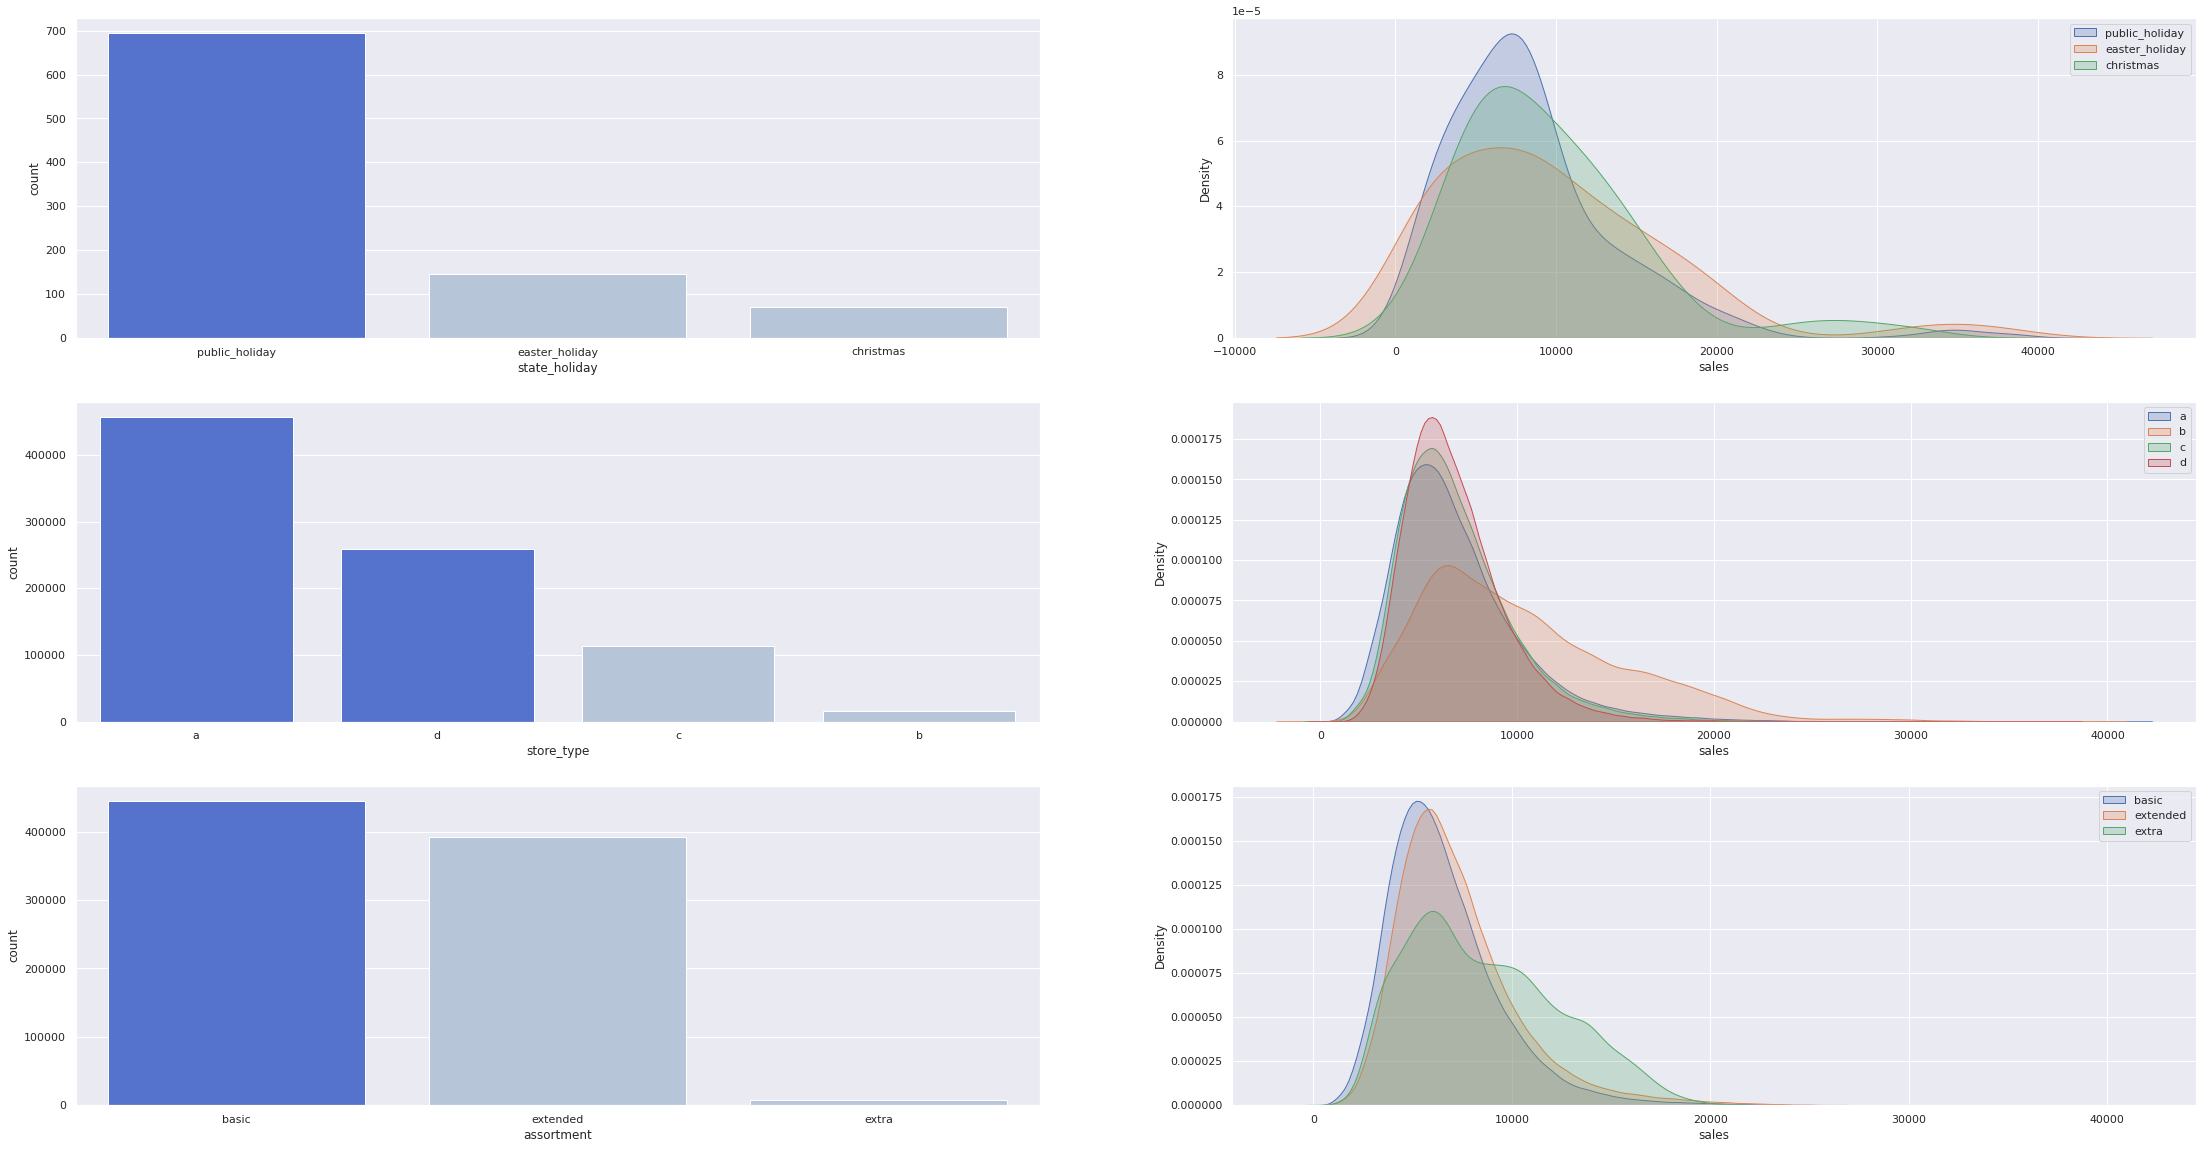

In [12]:
# state_holiday
sns.set(rc = {'figure.figsize' : (38,20)})

plt.subplot(3,2,1)
sns.countplot(cat_atrib.loc[cat_atrib['state_holiday'] != 'regular_day' , 'state_holiday'], palette= ['royalblue','lightsteelblue','lightsteelblue']);

plt.subplot(3,2,2)
sns.kdeplot(data=df[df['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(data=df[df['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(data=df[df['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend()

# story_type
plt.subplot(3,2,3)
sns.countplot(cat_atrib['store_type'], palette= ['royalblue','royalblue','lightsteelblue','lightsteelblue'], order='adcb');

plt.subplot(3,2,4)
sns.kdeplot(data=df[df['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(data=df[df['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(data=df[df['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(data=df[df['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(cat_atrib['assortment'], palette= ['royalblue','lightsteelblue','lightsteelblue']);

plt.subplot(3,2,6)
sns.kdeplot(data=df[df['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(data=df[df['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(data=df[df['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend()



#### 4.1. Análise Bivariada

##### 1. Lojas com maior sortimento deveriam vender mais.  

    True

"Hipótese validada. Extra detém   38.29%, o 'extended' e 'baisc' ficam respectivamente com  32.36% e   29.35% do total de vendas"

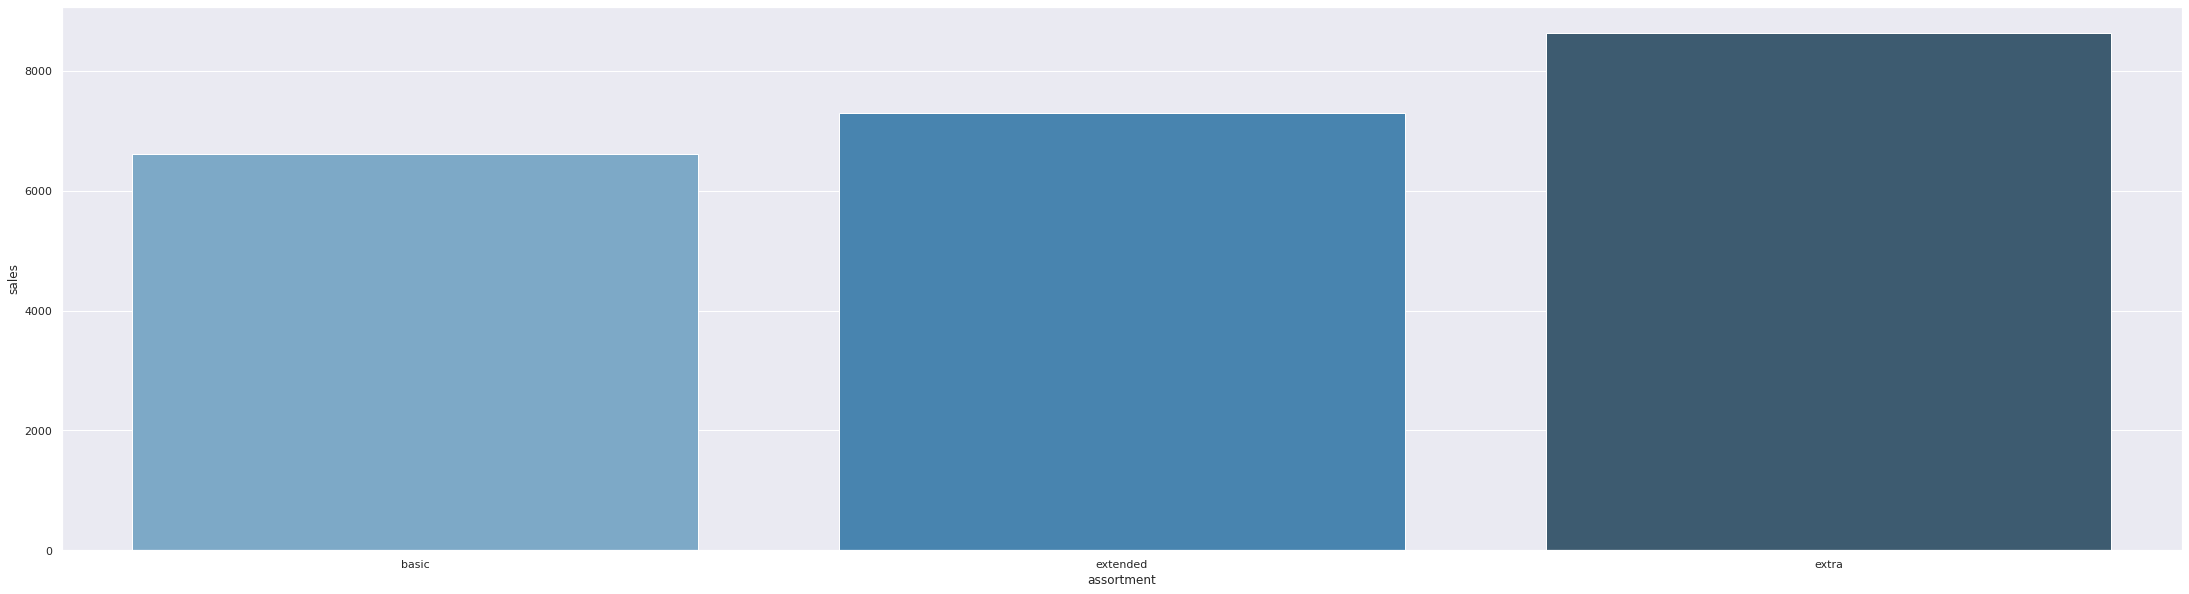

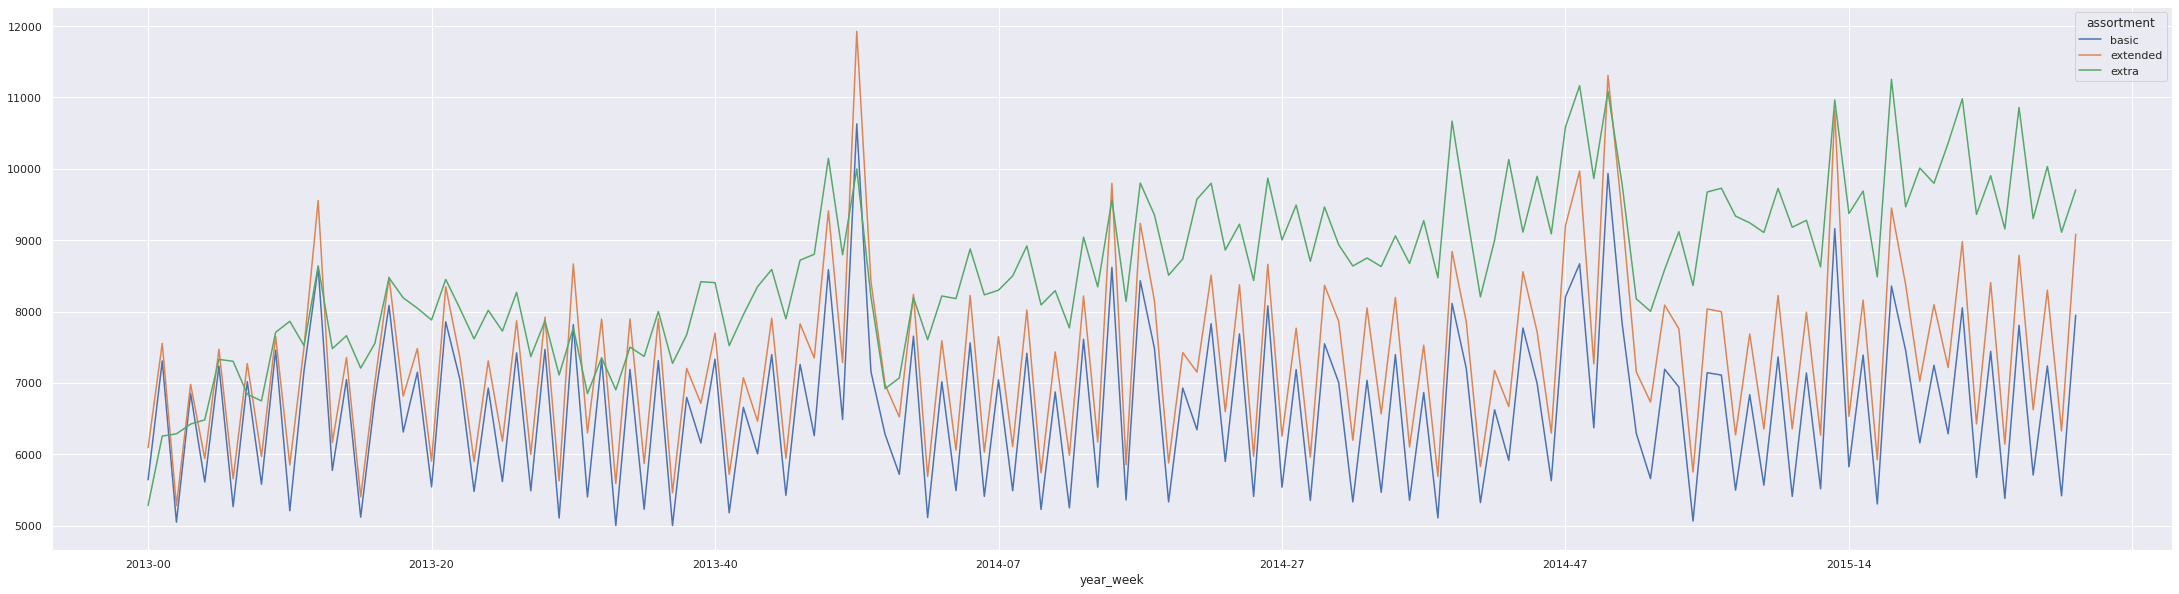

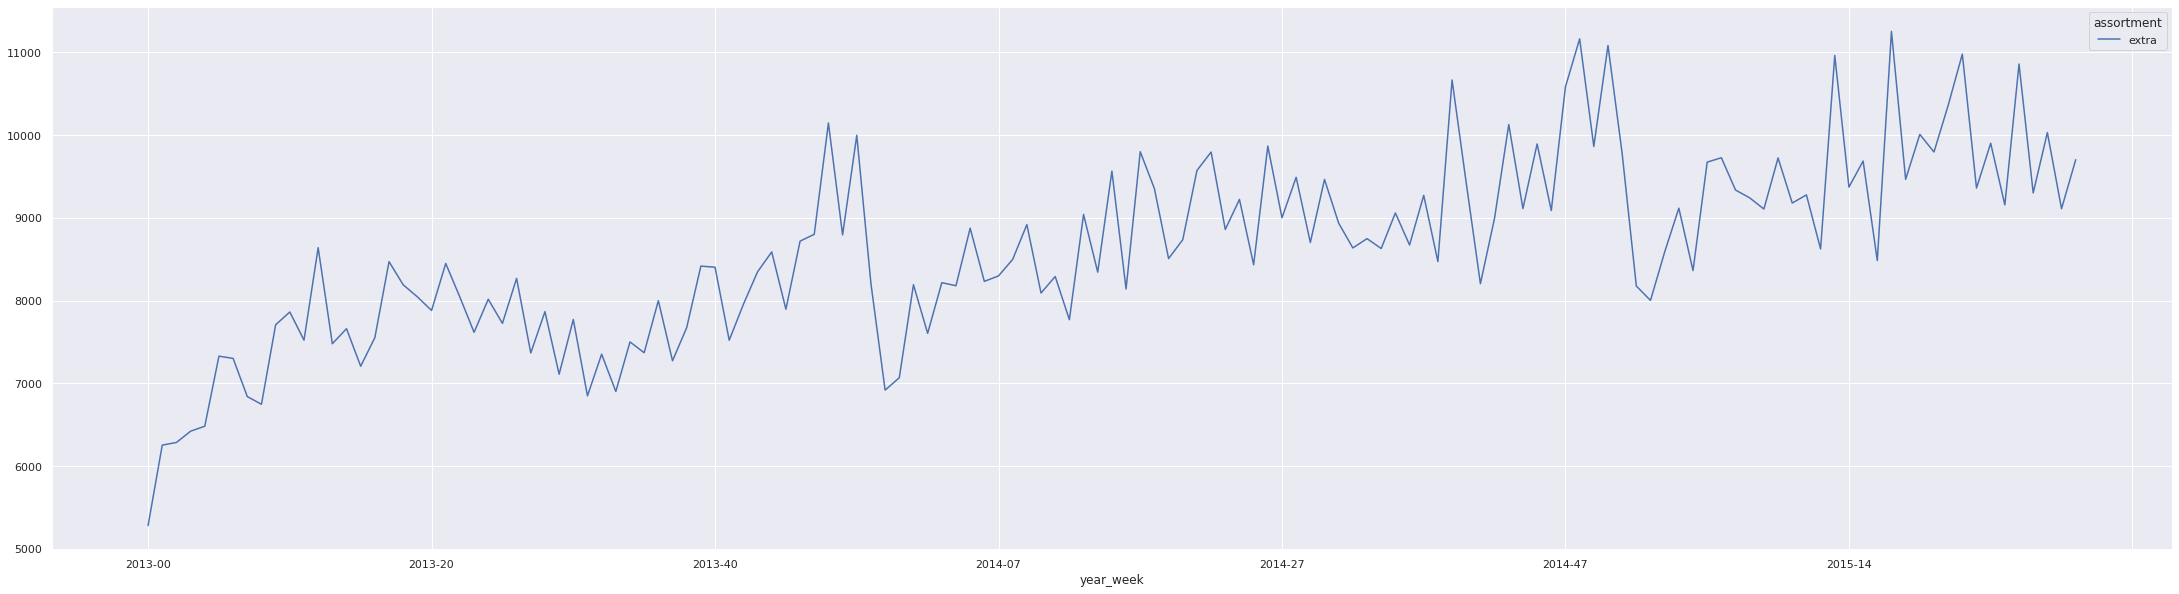

In [13]:
## Variável 01
sns.set(rc={'figure.figsize':(38,10)})
assortment = df[['assortment','sales']].groupby('assortment').mean().reset_index()
sns.barplot(data= assortment, x= 'assortment', y= 'sales', palette='Blues_d');

#Variável 02
assort_date = df[['year_week','assortment','sales']].groupby(['year_week','assortment']).mean().reset_index()
assort_date.pivot(index='year_week', columns='assortment', values='sales').plot()

#Comportamento isolado do extra
assort_date[assort_date['assortment'] == 'extra'].pivot(index='year_week', columns='assortment', values='sales').plot()



display(f"Hipótese validada. Extra detém  {float((assortment.loc[assortment['assortment'] == 'extra','sales'] ) / assortment['sales'].sum()): .2%}, \
o 'extended' e 'baisc' ficam respectivamente com {float((assortment.loc[assortment['assortment'] == 'extended','sales'] ) / assortment['sales'].sum()): .2%} e \
 {float((assortment.loc[assortment['assortment'] == 'basic','sales'] ) / assortment['sales'].sum()): .2%} do total de vendas")

##### 2. Lojas com competidores mais próximos deveriam vender menos.

    False.
    Não demonstra comportamento claro de ligação direta de distância com vendas. Variando bastante no decorrer da série.

In [14]:
#df.loc[df.competition_distance == df['competition_distance'].max(), 'competition_distance'] = 20000


In [15]:
comp_dist_sales = df[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()
bins = list(np.arange(0,20000,1000))
comp_dist_sales['comp_dist_bined'] = pd.cut(comp_dist_sales['competition_distance'], bins=bins)


<AxesSubplot:>

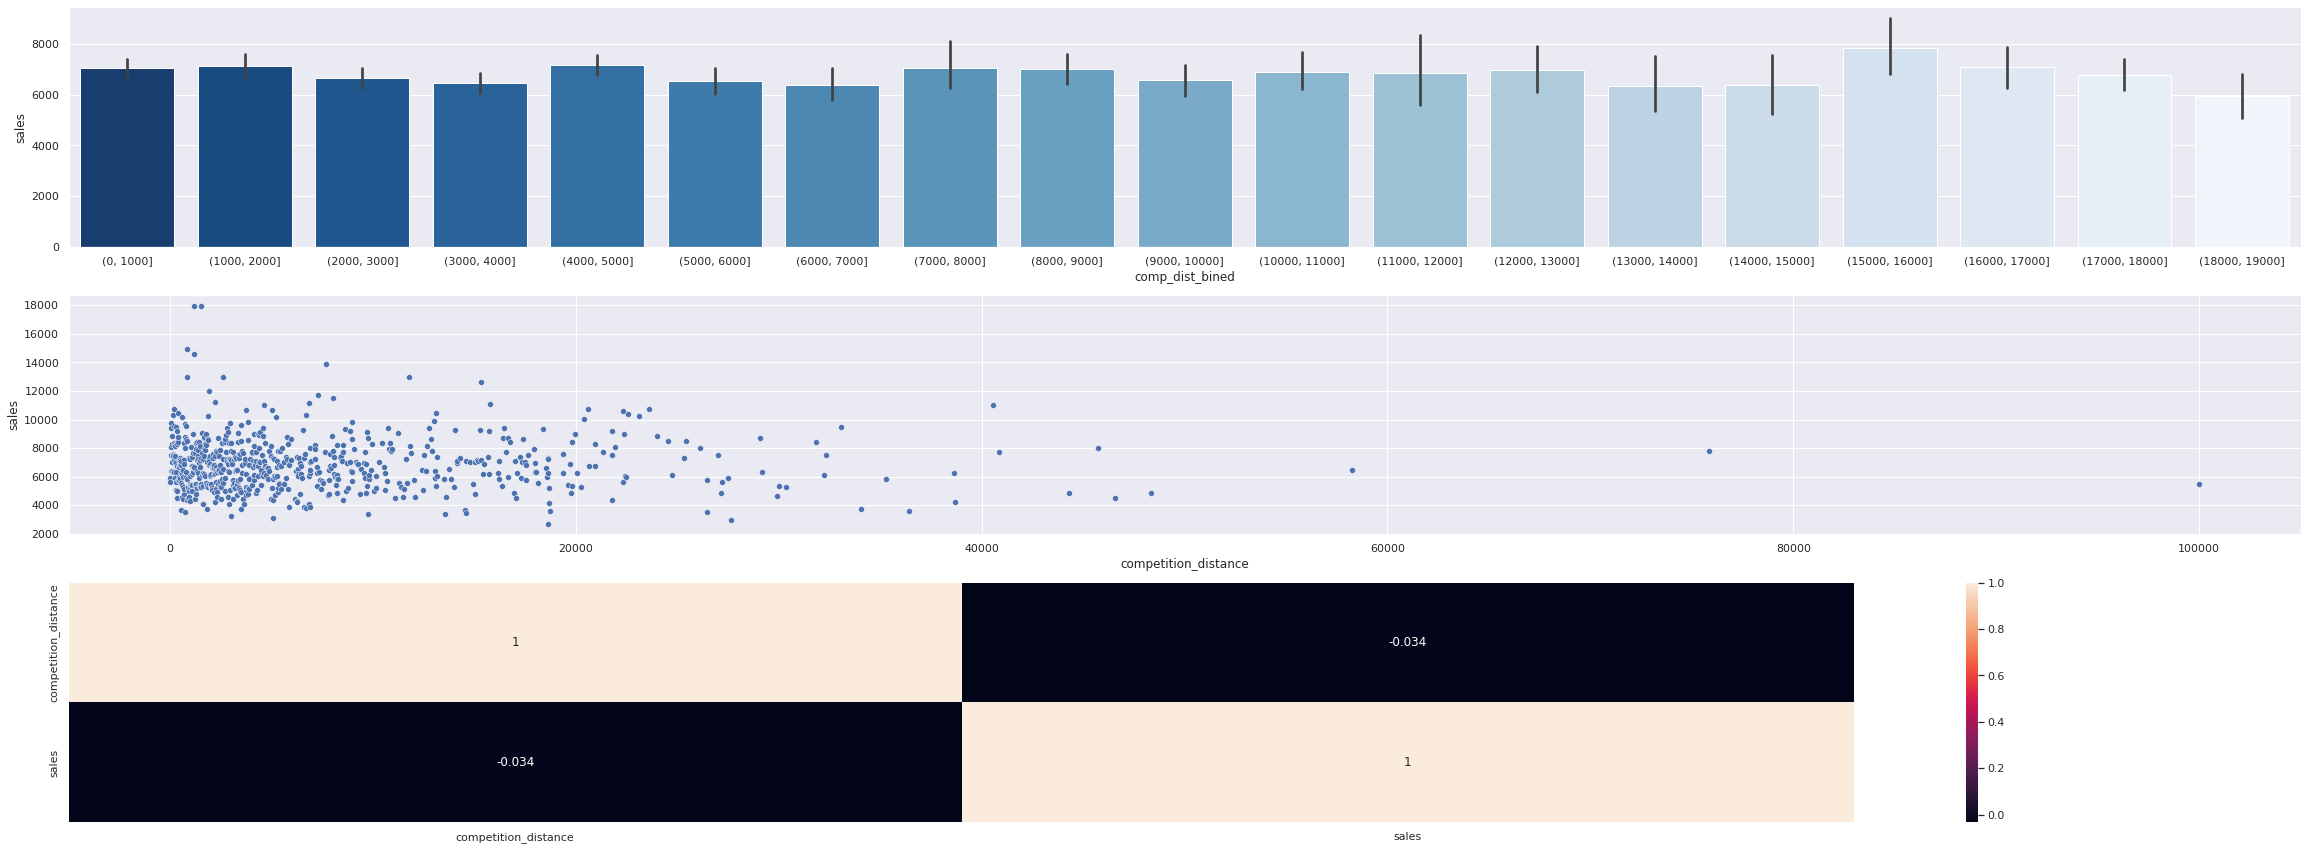

In [16]:
sns.set(rc={'figure.figsize':(40,15)})
plt.subplot(3,1,1)
sns.barplot(data= comp_dist_sales, x='comp_dist_bined', y='sales', palette='Blues_r');

plt.subplot(3,1,2)
sns.scatterplot(data=comp_dist_sales, x='competition_distance', y='sales' );

plt.subplot(3,1,3)
sns.heatmap(comp_dist_sales.corr(method='pearson'), annot=True)


##### 3. Lojas com competidores a mais tempo deveriam vender menos.    

    True. 
    Apesar de ser uma queda muito pequena nas vendas, há uma tendência de ascendente no número de vendas no decorrer do tempo.

In [17]:
comp_osm = df[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
comp_osm1 = comp_osm[(comp_osm['competition_time_month']<120) & (comp_osm['competition_time_month'] !=0)]

In [18]:
df.competition_time_month.min()

-32

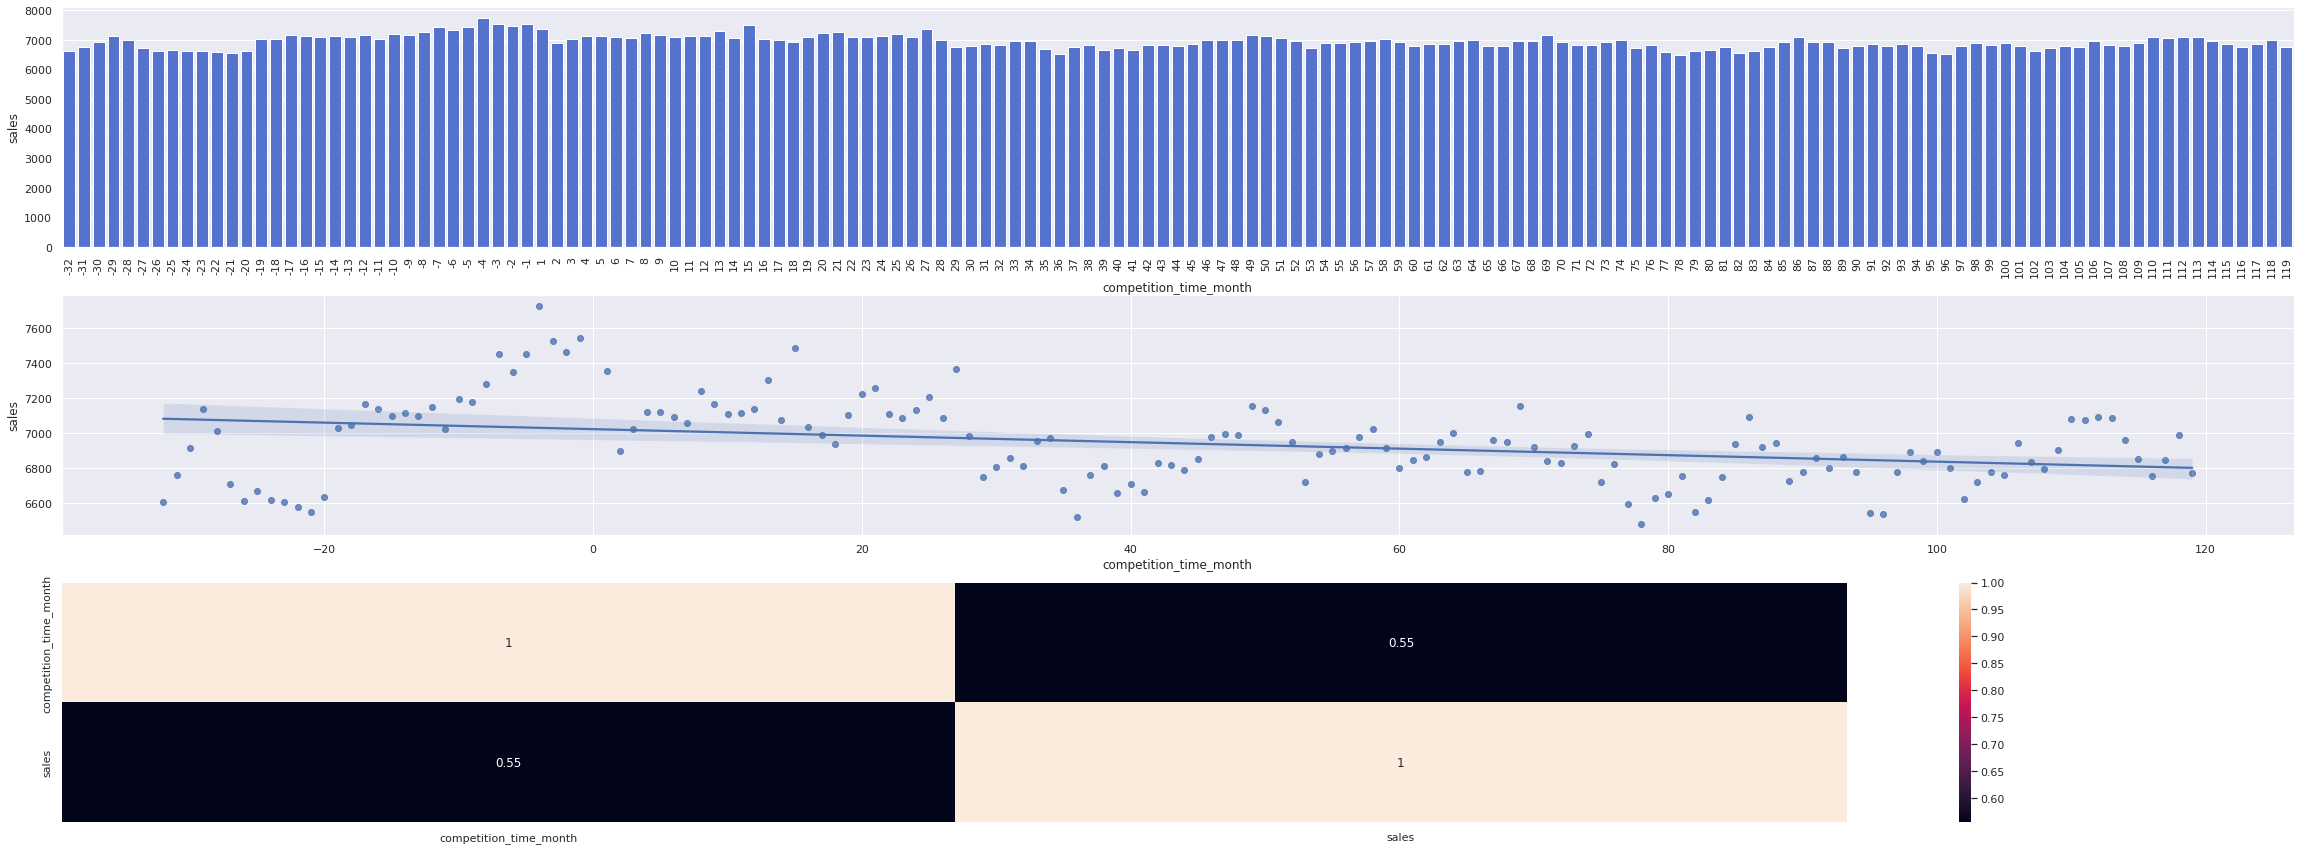

In [19]:
plt.subplot(3,1,1)
sns.barplot(data=comp_osm1, x='competition_time_month', y='sales', color='royalblue');
plt.xticks(rotation=90);

plt.subplot(3,1,2)
sns.regplot(data=comp_osm1, x='competition_time_month', y='sales');

plt.subplot(3,1,3)
sns.heatmap(comp_osm.corr(method='pearson'), annot=True);

#####  4. Lojas com promoções ativas por mais tempo deveriam vender mais.

    True. 
    Lojas com promoções ativas por muito tempo, tem uma queda considerável nas vendas após certo período mas ainda acima do valor médio.

In [20]:
promo_sales_geral = df[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()
promo_sales = df.loc[df.promo_time_week > 0 ,['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
trad_sales = df.loc[df.promo_time_week < 0 ,['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

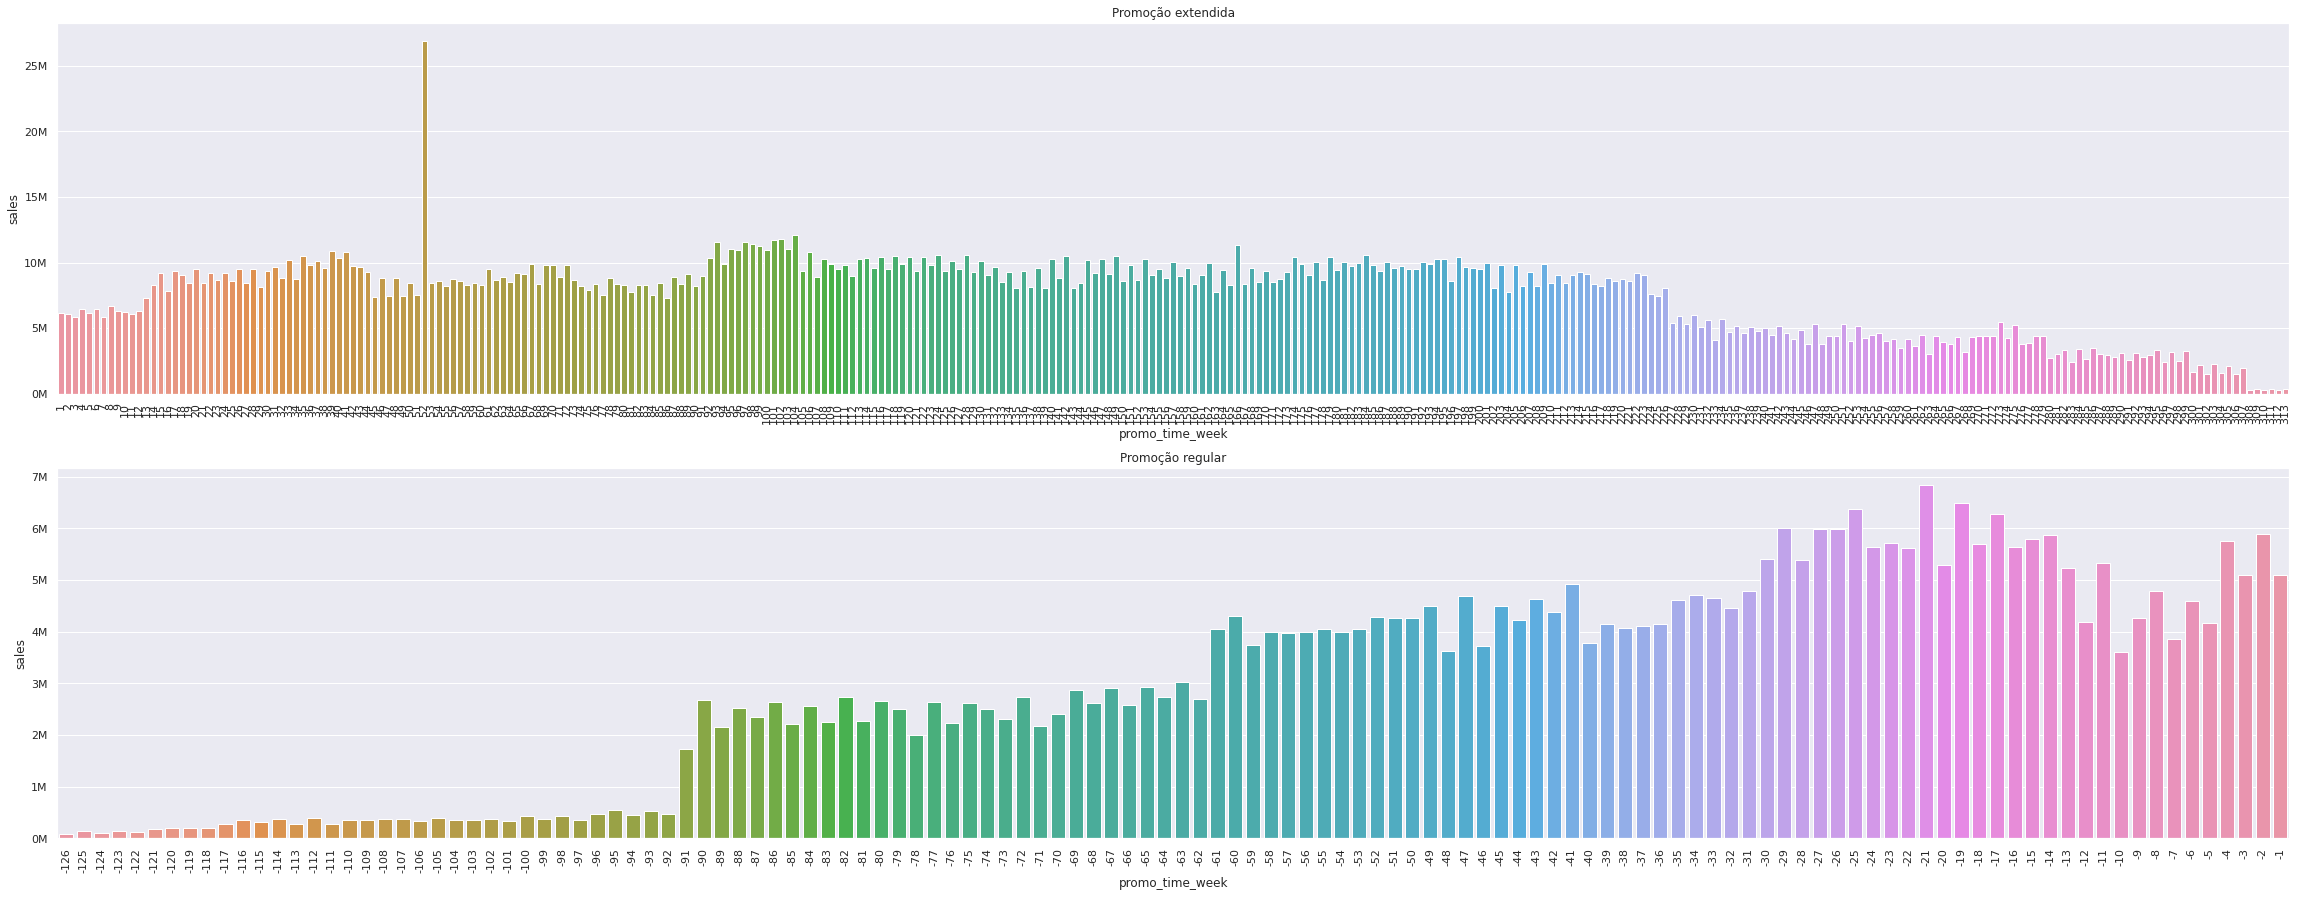

In [21]:
plt.subplot(2,1,1)
fig = sns.barplot(data=promo_sales, x='promo_time_week', y='sales');
xlabels = ['{:,.0f}'.format(x) + 'M' for x in fig.get_yticks()/1000000]
fig.set_yticklabels(xlabels);
plt.xticks(rotation=90);
plt.title('Promoção extendida');

plt.subplot(2,1,2)
fig = sns.barplot(data=trad_sales, x='promo_time_week', y='sales');
xlabels = ['{:,.0f}'.format(x) + 'M' for x in fig.get_yticks()/1000000]
fig.set_yticklabels(xlabels);
plt.xticks(rotation=90);
plt.title('Promoção regular');


<AxesSubplot:xlabel='promo_time_week', ylabel='sales'>

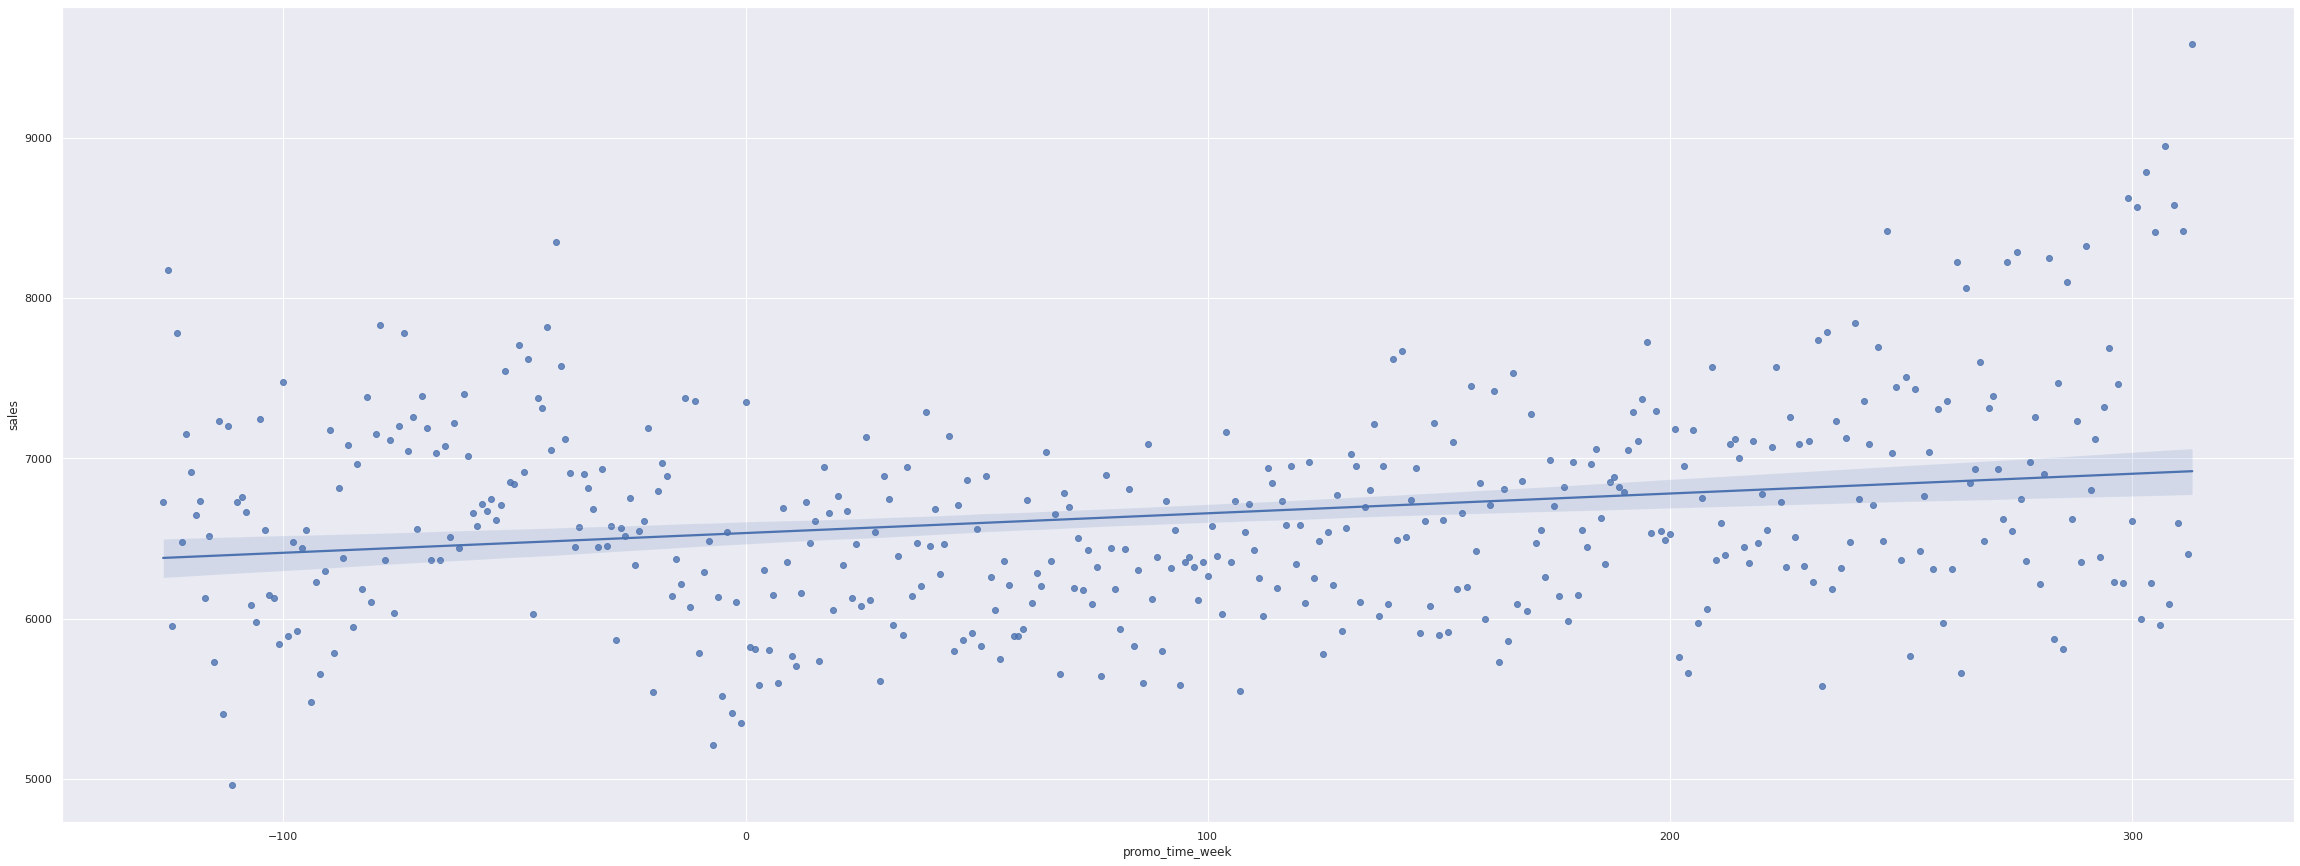

In [22]:
sns.regplot(data = promo_sales_geral, x= 'promo_time_week', y='sales')

<AxesSubplot:>

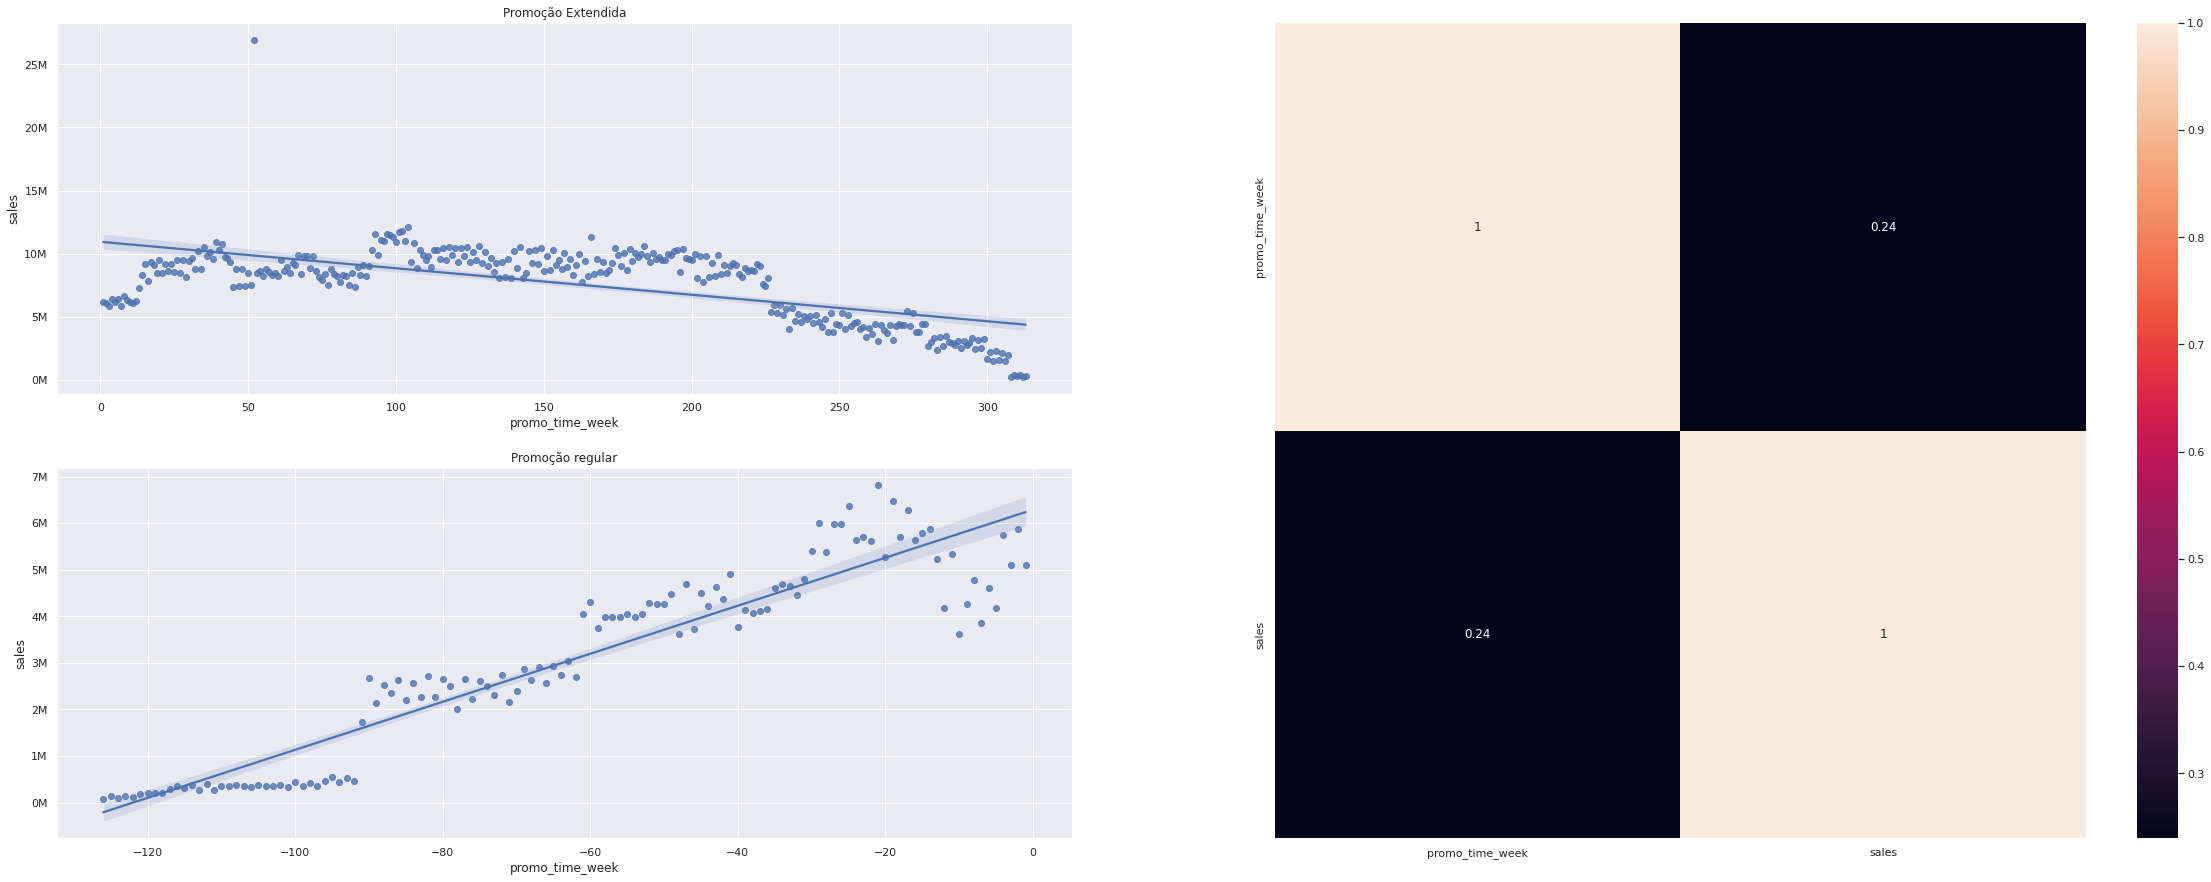

In [23]:
grid = plt.GridSpec(2,2)

plt.subplot(grid[0,0])
fig = sns.regplot(data=promo_sales, x='promo_time_week', y='sales');
xlabels = ['{:,.0f}'.format(x) + 'M' for x in fig.get_yticks()/1000000]
fig.set_yticklabels(xlabels);
plt.title('Promoção Extendida');


plt.subplot(grid[1,0])
fig = sns.regplot(data=trad_sales, x='promo_time_week', y='sales');
xlabels = ['{:,.0f}'.format(x) + 'M' for x in fig.get_yticks()/1000000]
fig.set_yticklabels(xlabels);
plt.title('Promoção regular');

plt.subplot(grid[:,1])
sns.heatmap(promo_sales_geral.corr(method='pearson'), annot=True)



##### <s> 5. Lojas com mais dias de promoção deveriam vender mais. </s>    

##### 6. Lojas com mais promoções consecutivas deveriam vender mais.  

    False

In [24]:
df[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index().sort_values('sales', ascending=False)

,promo,promo2,sales
2,1,0,8618.132880
3,1,1,7836.089044
0,0,0,6327.971557
1,0,1,5528.973894


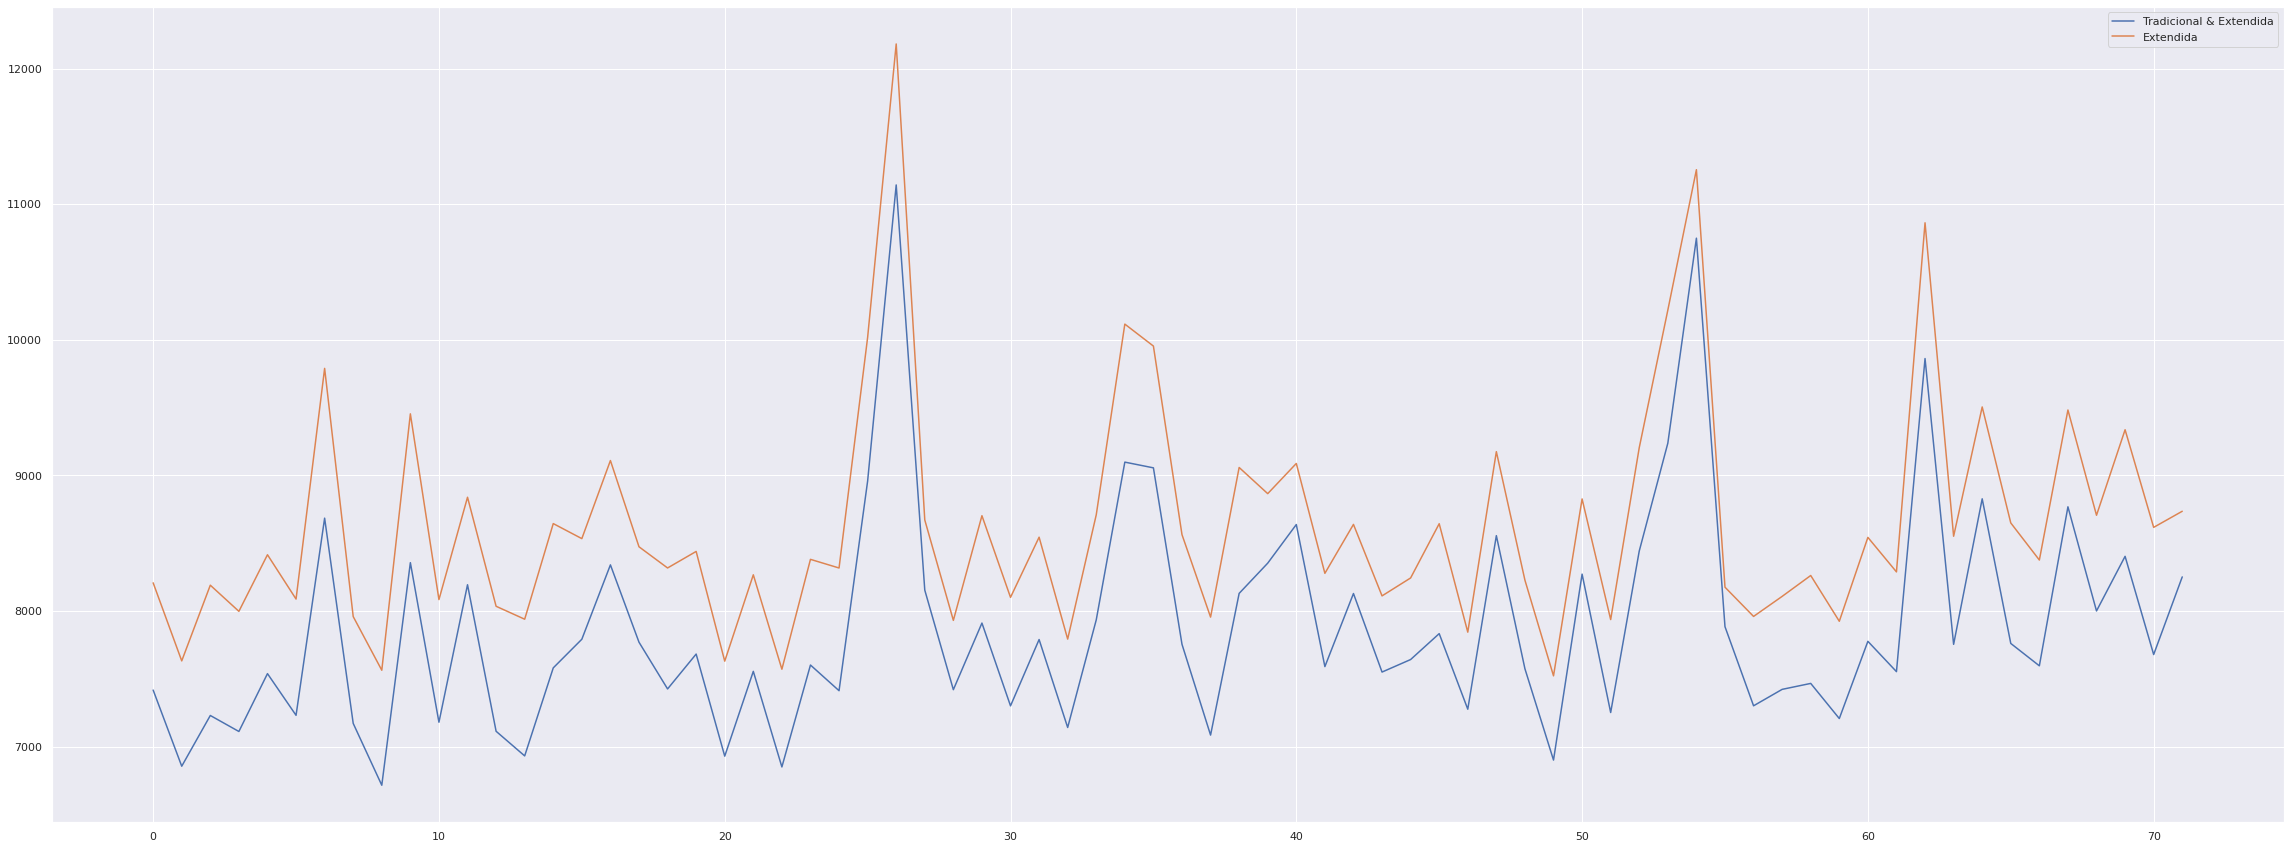

In [25]:
temp = df[(df['promo'] == 1) & (df['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
ax = temp.plot()

temp1 = df[(df['promo'] == 1) & (df['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
ax2 = temp1.plot(ax = ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida'])


##### 7. Lojas que abrem durante o feriado de natal deveriam vender mais. 

    False
    Em um contexto geral, vende-se mais em 'easter_holiday' mas com uma pequena margem de diferênça.
    Se analisado isoladamente, em 2014 foram computadas mais vendas em 'christmas' do que nos demais.

<AxesSubplot:xlabel='year', ylabel='sales'>

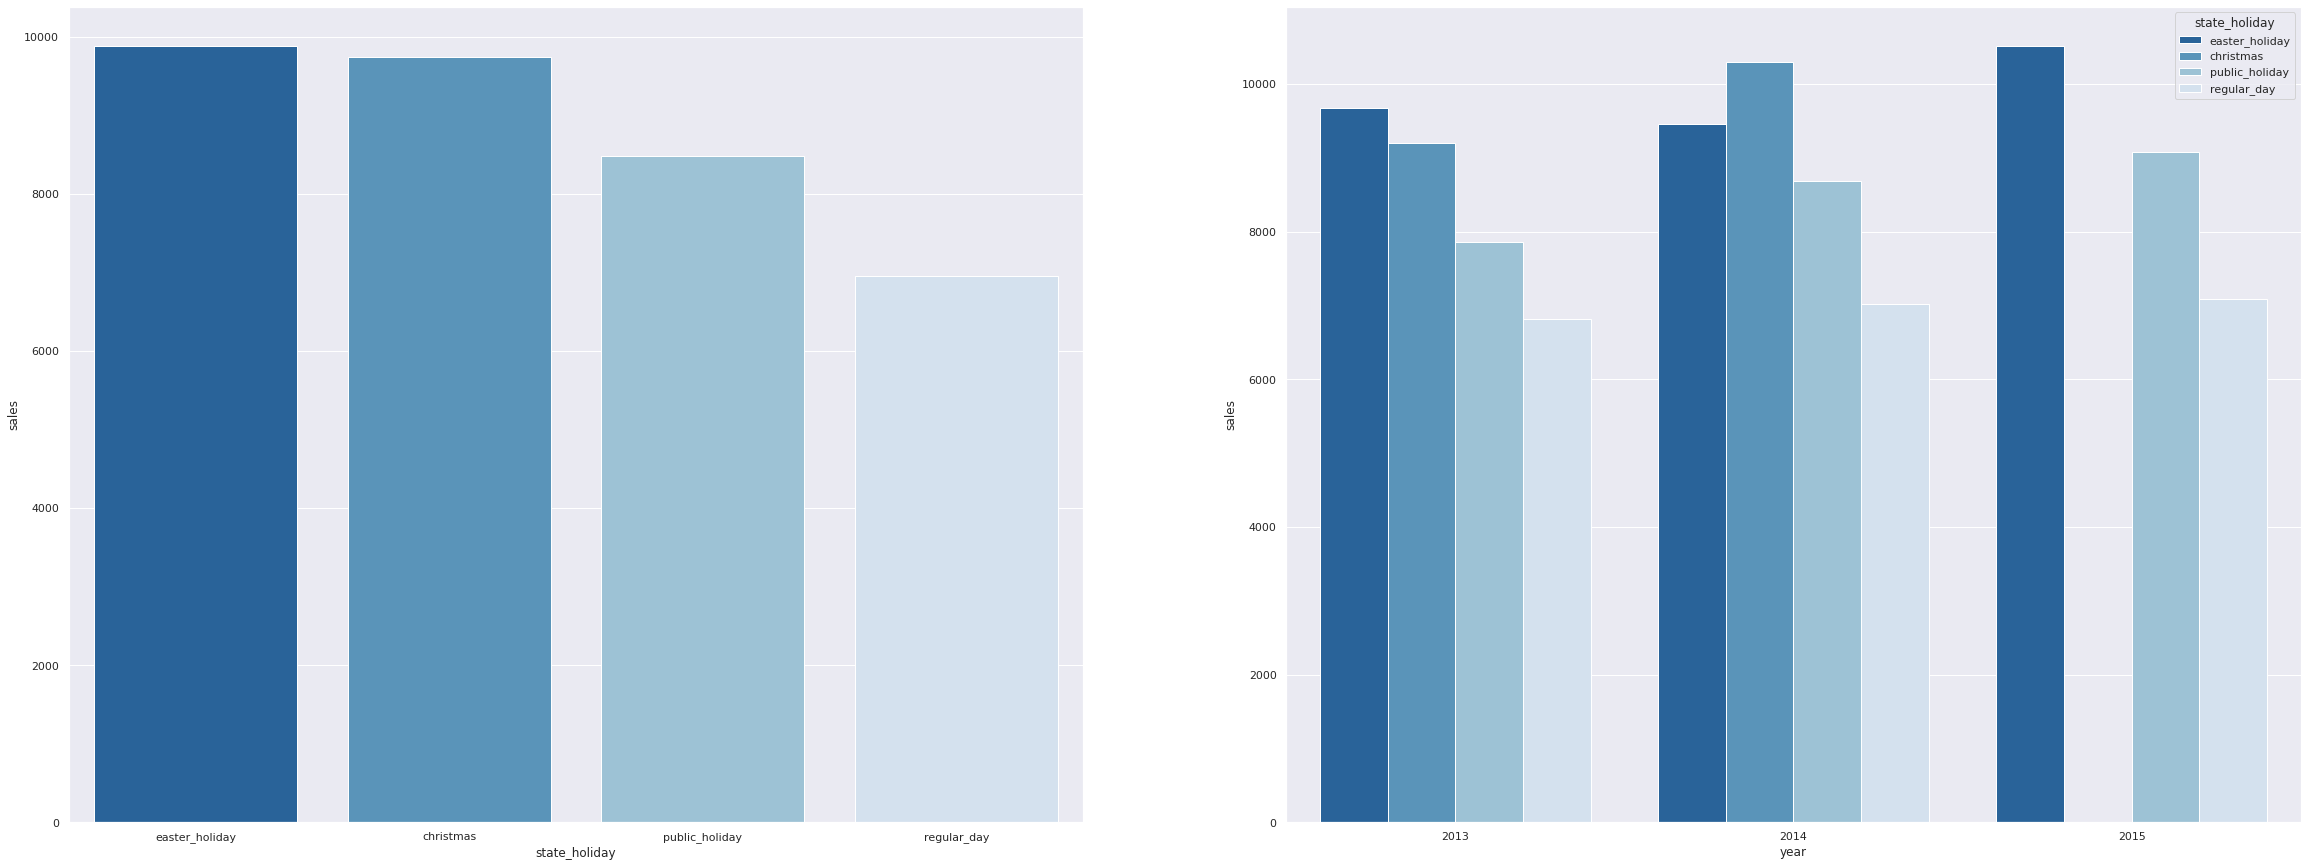

In [26]:
temp = df[['state_holiday', 'sales']].groupby('state_holiday').mean().sort_values('sales', ascending=False).reset_index()

#graph 1
plt.subplot(1,2,1)
sns.barplot(data=temp, x='state_holiday', y='sales', palette='Blues_r')

#graph2
temp1 = df[['year','state_holiday', 'sales']].groupby(['year','state_holiday']).mean().sort_values('sales', ascending=False).reset_index()
plt.subplot(1,2,2)
sns.barplot(data=temp1, x='year', y='sales',hue='state_holiday', palette='Blues_r')


##### 8. Lojas deveriam vender mais ao longo dos anos.

    False. Com o passar dos anos, as lojas mostram uma clara tendência decrescente no montante de vendas.

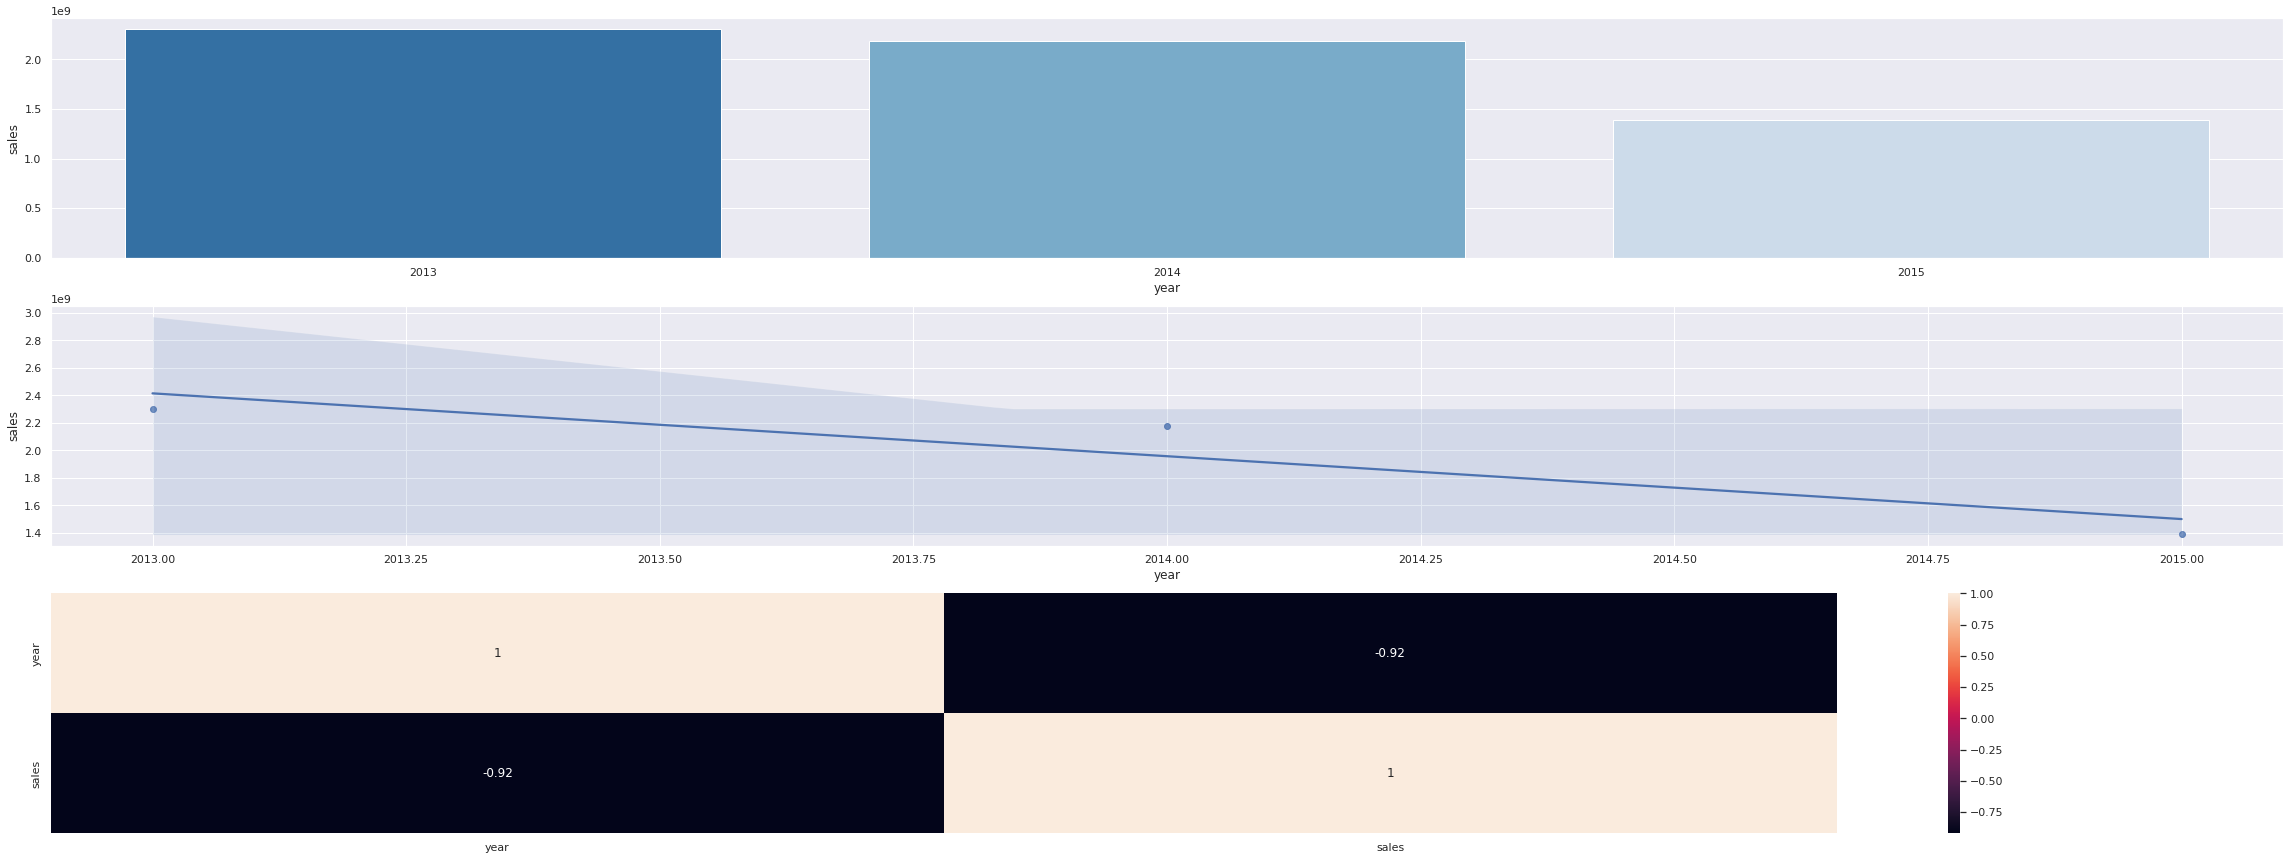

In [39]:
temp =  df[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(3,1,1)
sns.barplot(data=temp, x='year',y='sales', palette='Blues_r');

plt.subplot(3,1,2)
sns.regplot(data=temp, x='year',y='sales');

plt.subplot(3,1,3)
sns.heatmap(temp.corr(method='pearson'),annot=True);


##### 9. Lojas deveriam vender mais no segundo semestre do ano.

    Verdadeiro. Se for desconsiderado o ano de 2015(que está com informações referentes somente até o mês 7), nota-se uma pequeno nível de crescimento 

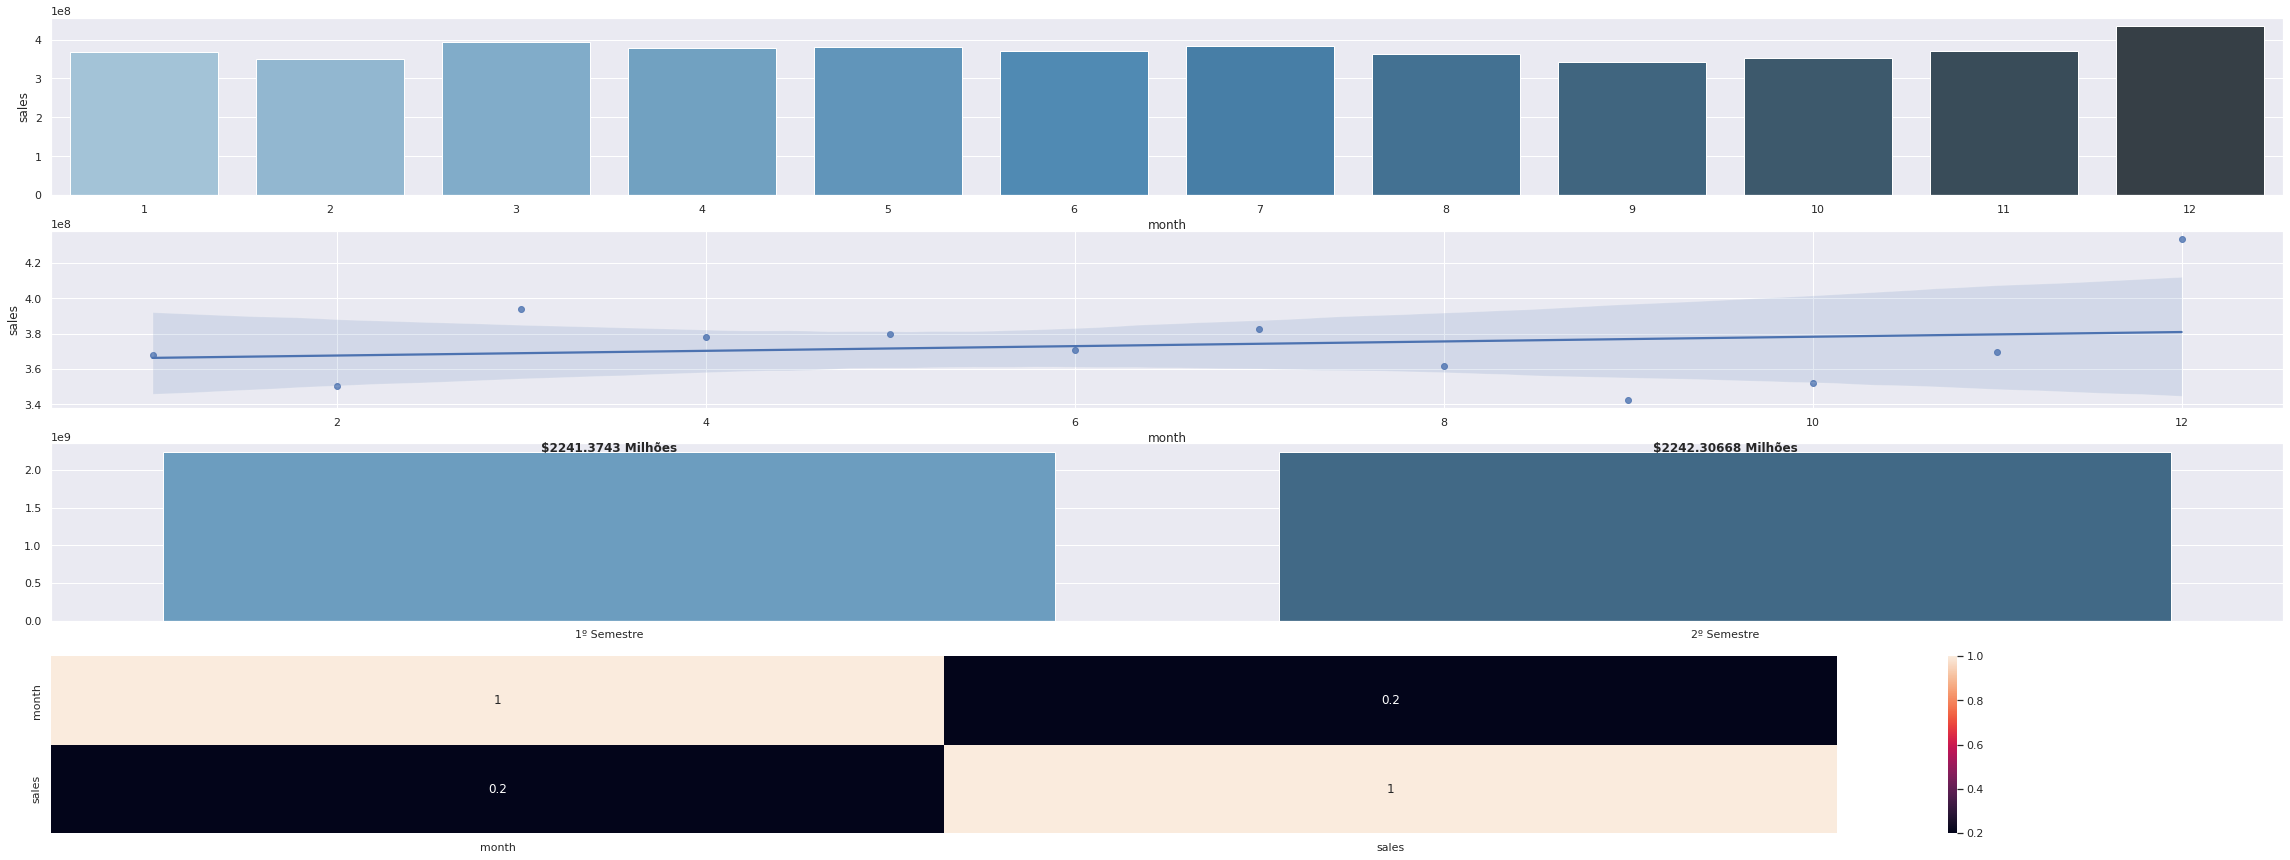

In [71]:
temp = df.loc[df['year'] < 2015, ['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(4,1,1)
sns.barplot(data=temp, x='month', y='sales', palette='Blues_d')

plt.subplot(4,1,2)
sns.regplot(data=temp, x='month', y='sales')

plt.subplot(4,1,4)
sns.heatmap(temp.corr(method='pearson'), annot=True)

plt.subplot(4,1,3)
ax = sns.barplot(data=temp, x=['1º Semestre', '2º Semestre'], y=[temp.loc[temp['month'] <= 6, 'sales'].sum(),temp.loc[temp['month'] >= 7, 'sales'].sum()], palette='Blues_d')
for i in ax.patches:
    ax.annotate(
        #Texto a ser plotado
        '$' + str(i.get_height() / 1000000) + ' Milhões',
        #Posição horizontal
        (i.get_x() + i.get_width() /2, i.get_height() + 10),
        ha='center' ,
        weight='bold'       
     );


##### 10. Lojas deveriam vender mais após o dia 10 de cada mês.

    False. Lojas tem média de vendas maior, antes do dia 10

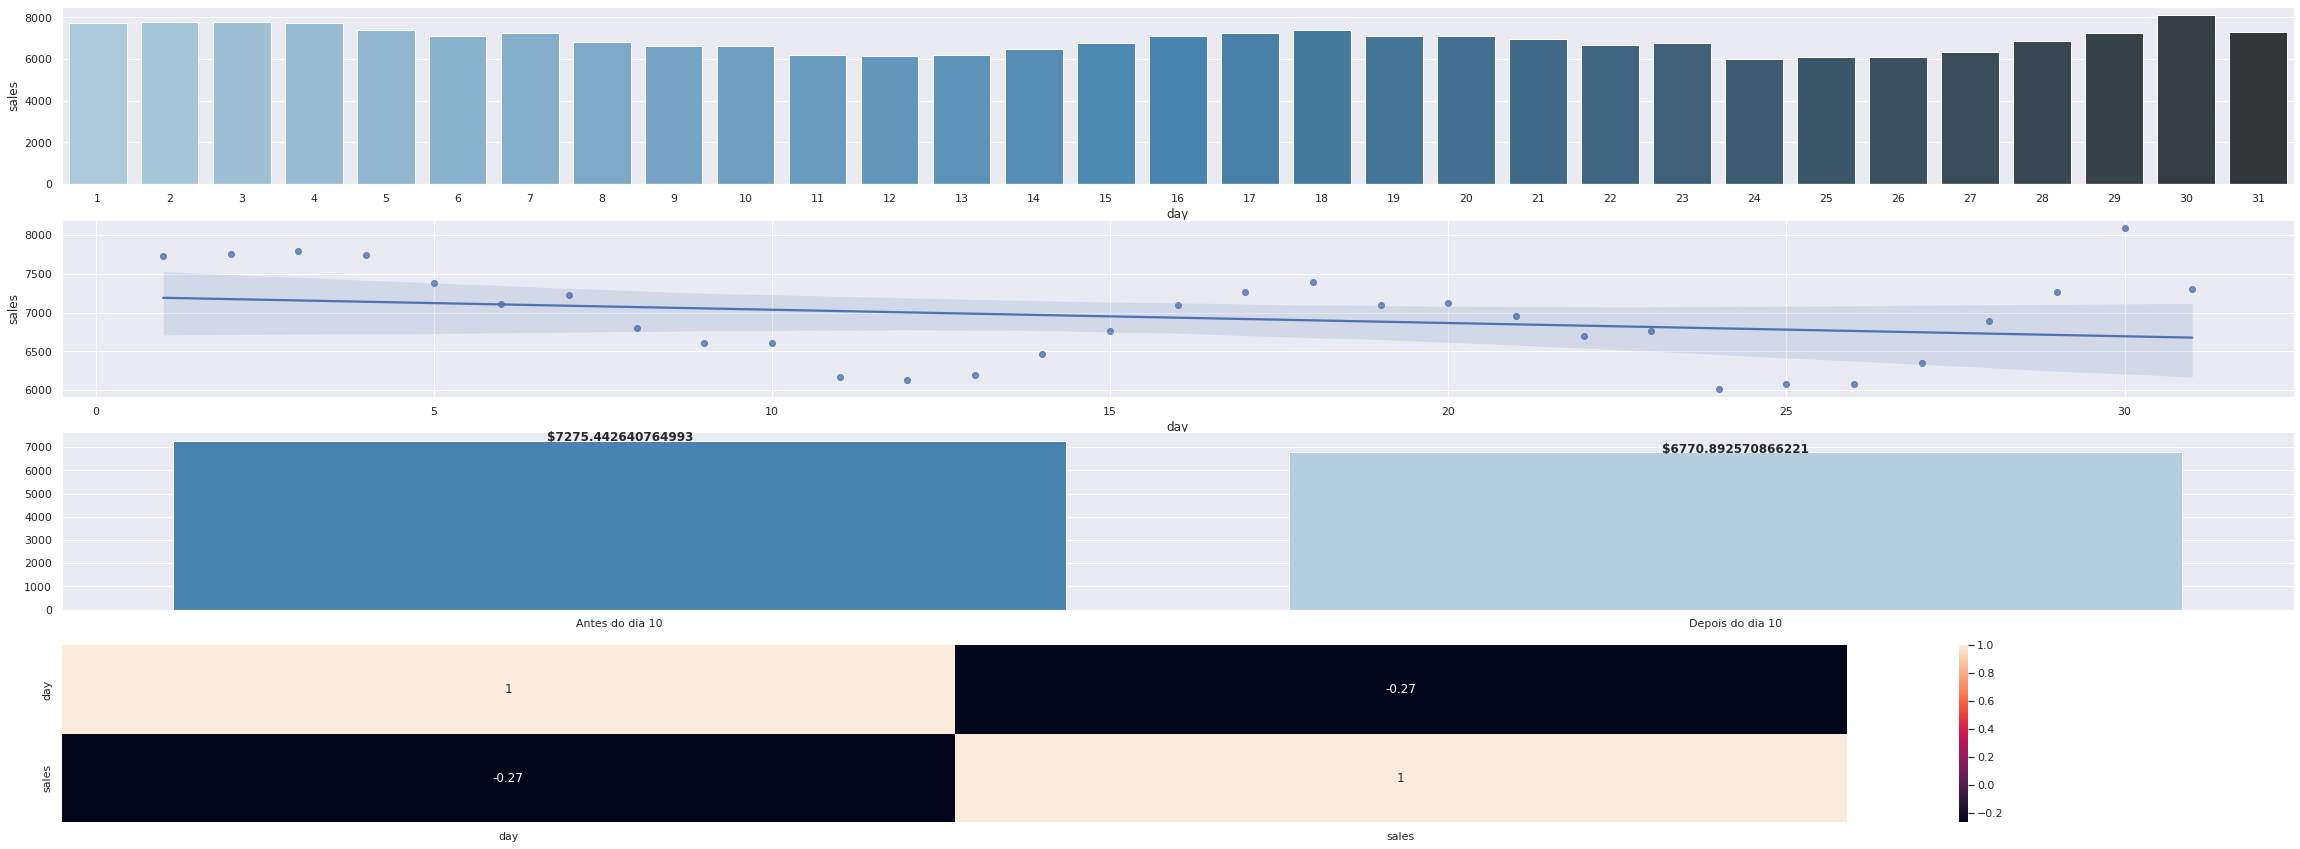

In [105]:
temp = df.loc[df['year'] < 2015, ['day', 'sales']].groupby('day').mean().reset_index()

plt.subplot(4,1,1)
sns.barplot(data=temp, x='day', y='sales', palette='Blues_d')

plt.subplot(4,1,2)
sns.regplot(data=temp, x='day', y='sales')

plt.subplot(4,1,4)
sns.heatmap(temp.corr(method='pearson'), annot=True)

plt.subplot(4,1,3)
ax = sns.barplot(data=temp, x=['Antes do dia 10', 'Depois do dia 10'], y=[temp.loc[temp['day'] <= 10, 'sales'].mean(),temp.loc[temp['day'] > 10, 'sales'].mean()], palette='Blues_r')
for i in ax.patches:
    ax.annotate(
        #Texto a ser plotado
        '$' + str(i.get_height()),
        #Posição horizontal
        (i.get_x() + i.get_width() /2, i.get_height() + 10),
        ha='center' ,
        weight='bold'       
     );

##### 11. Lojas deveriam vender menos aos fins de semana.

    True.
    Lojas tem uma média menor de vendas aos fins de semana

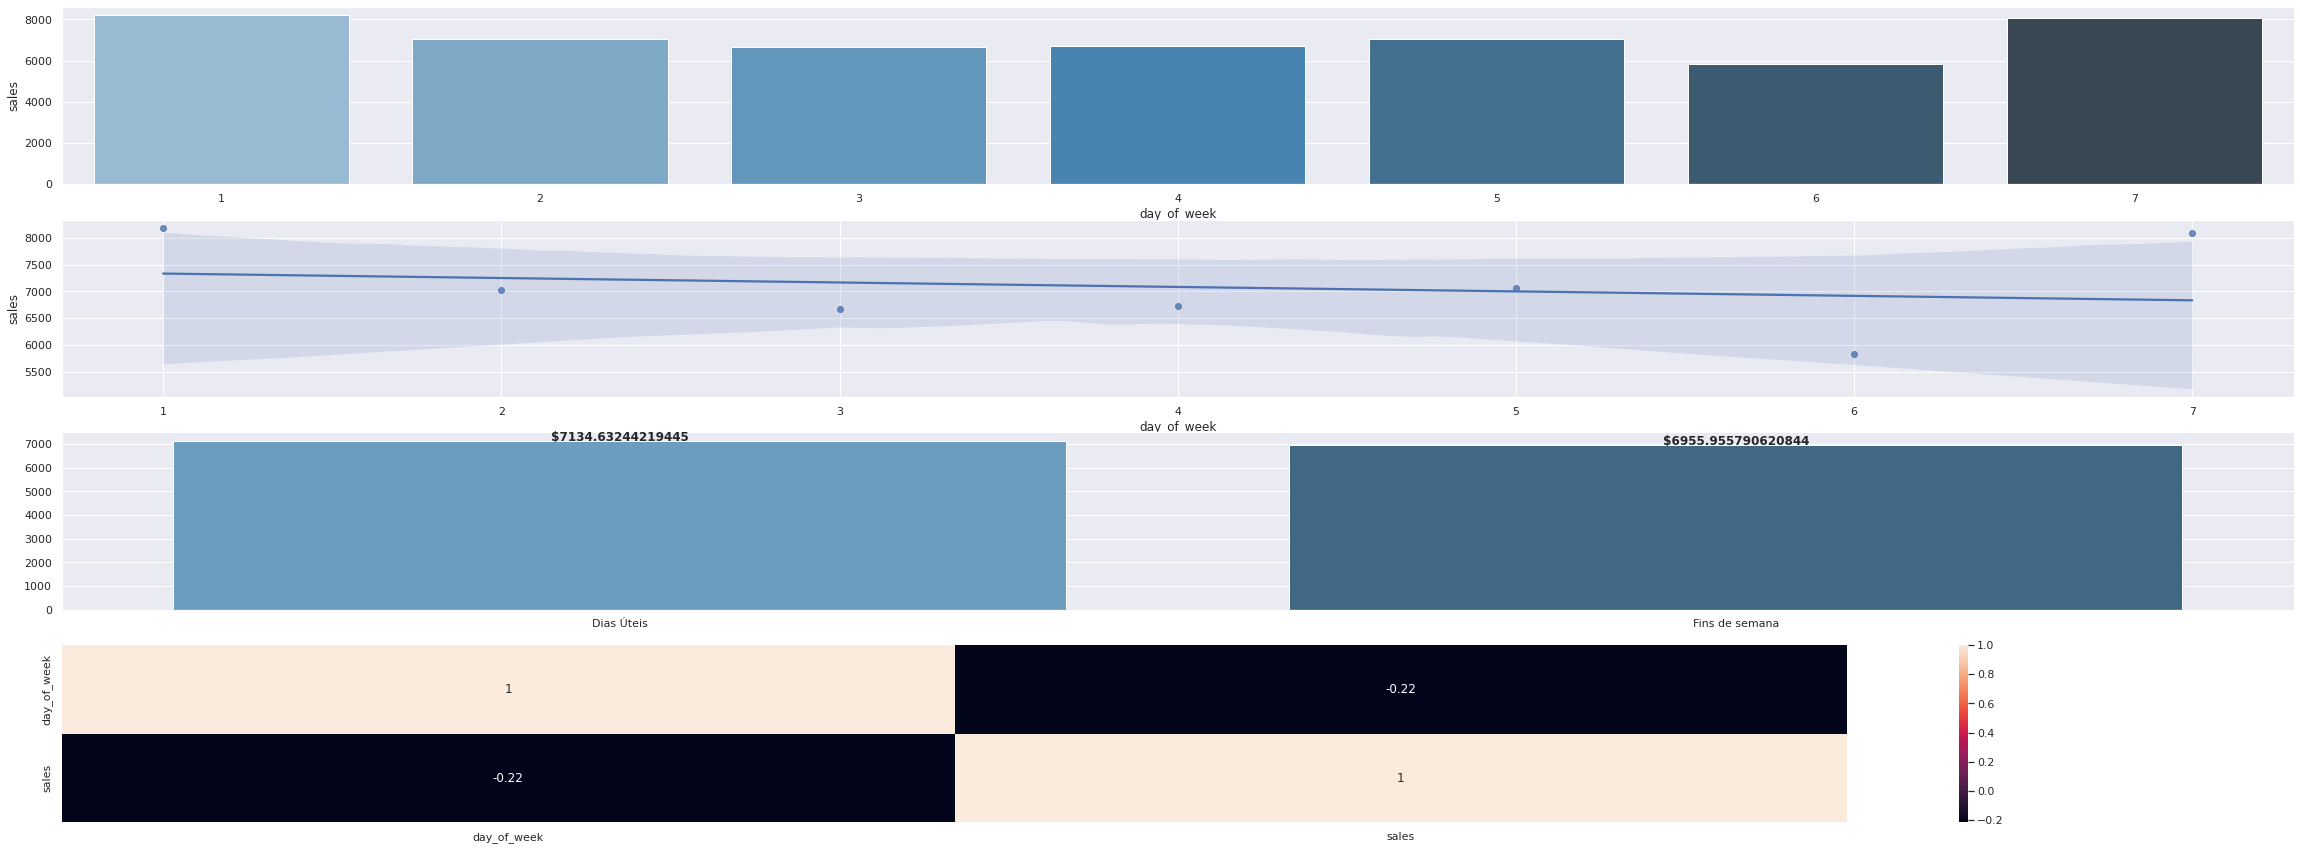

In [111]:
temp = df.loc[df['year'] < 2015, ['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()

plt.subplot(4,1,1)
sns.barplot(data=temp, x='day_of_week', y='sales', palette='Blues_d')

plt.subplot(4,1,2)
sns.regplot(data=temp, x='day_of_week', y='sales')

plt.subplot(4,1,4)
sns.heatmap(temp.corr(method='pearson'), annot=True)

plt.subplot(4,1,3)
ax = sns.barplot(data=temp, x=['Dias Úteis', 'Fins de semana'], y=[temp.loc[temp['day_of_week'] <= 5, 'sales'].mean(),temp.loc[temp['day_of_week'] > 5, 'sales'].mean()], palette='Blues_d')
for i in ax.patches:
    ax.annotate(
        #Texto a ser plotado
        '$' + str(i.get_height()) ,
        #Posição horizontal
        (i.get_x() + i.get_width() /2, i.get_height() + 10),
        ha='center' ,
        weight='bold'       
     );


##### 12. Lojas deveriam vender menos durante o feriados escolares.

    Falso. 
    Lojas tem uma média maior de vendas em feriados escolares. O que se repete por todo ano menos no mês de setembro onde as vendas são iguais e  Dezembro onde as vendas dos dias letivos, superam.

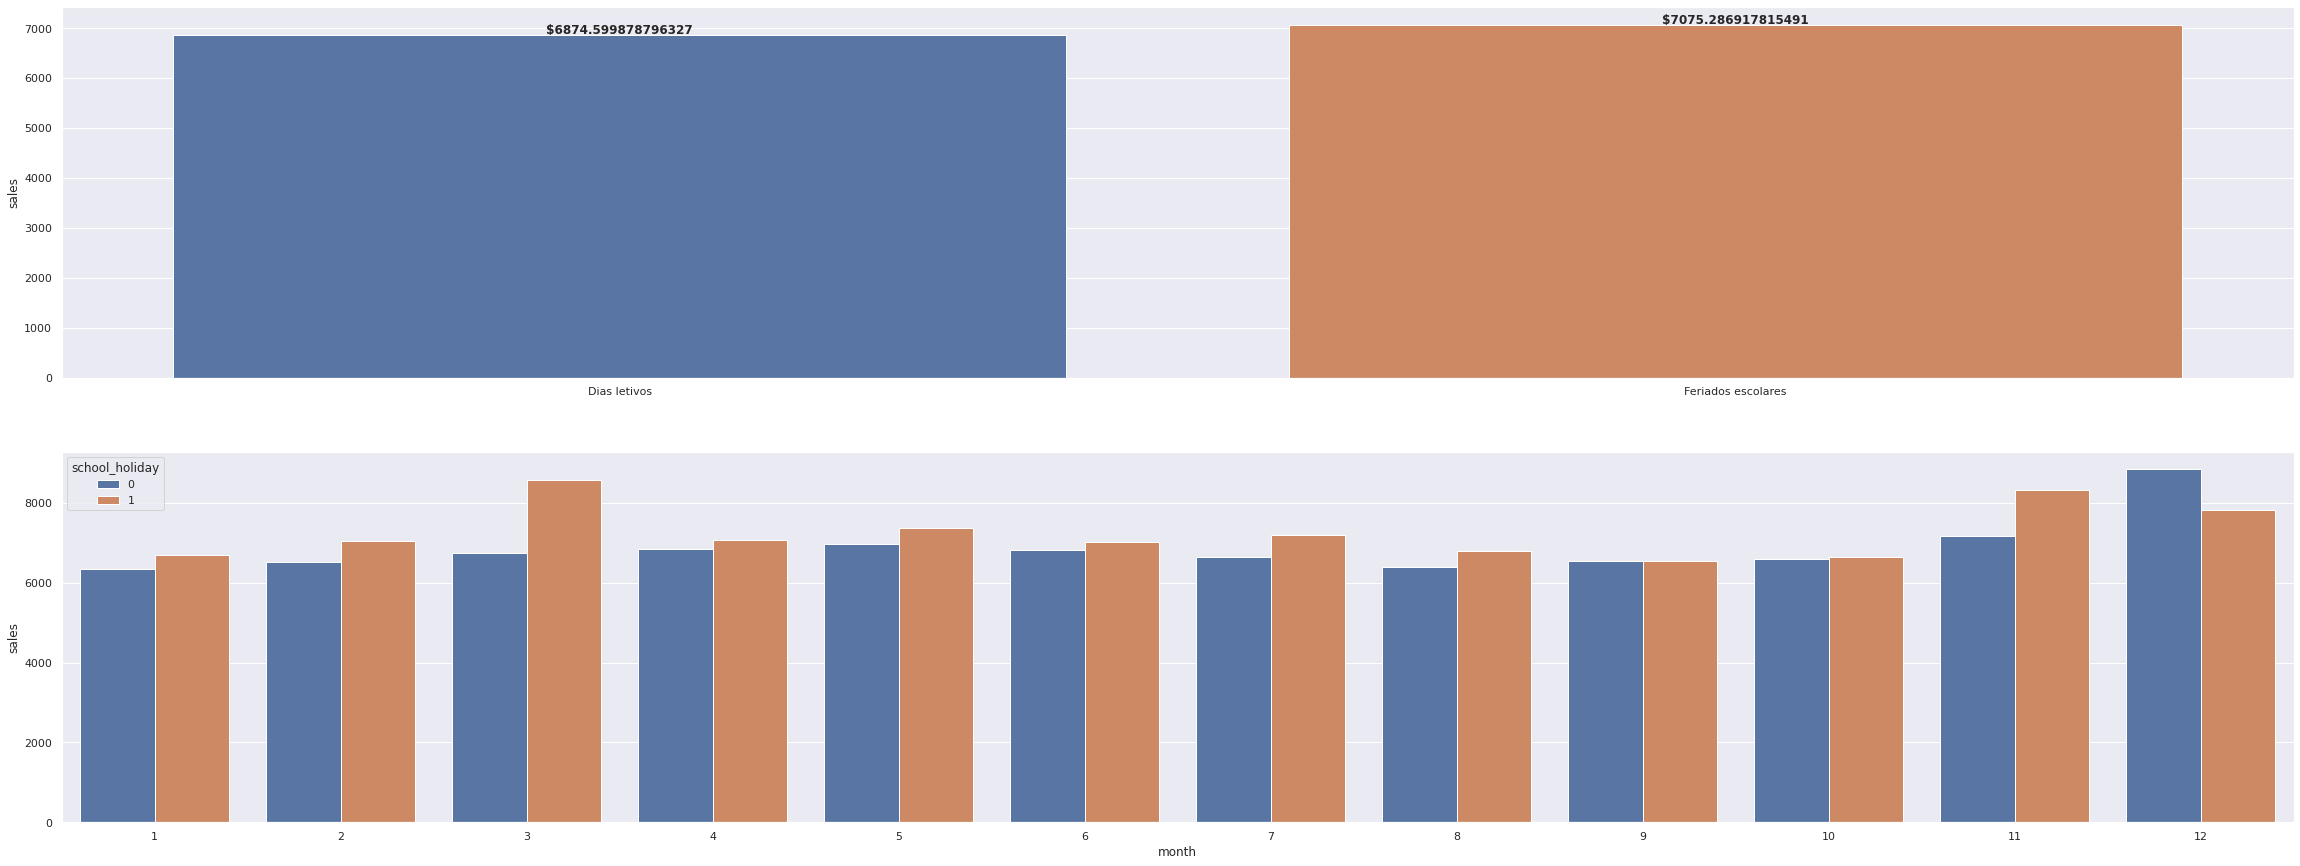

In [134]:
temp = df.loc[df['year'] < 2015, ['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()
temp1 = df.loc[df['year'] < 2015, ['month','school_holiday', 'sales']].groupby(['month','school_holiday']).mean().reset_index()


plt.subplot(2,1,1)
ax = sns.barplot(data=temp, x=['Dias letivos', 'Feriados escolares'], y='sales')
for i in ax.patches:
    ax.annotate(
        #Texto a ser plotado
        '$' + str(i.get_height())  ,
        #Posição horizontal
        (i.get_x() + i.get_width() /2, i.get_height() + 10),
        ha='center' ,
        weight='bold'       
     );

plt.subplot(2,1,2)
ax1 = sns.barplot(data=temp1, x='month', y='sales', hue='school_holiday')





#### 4.1. Análise Multivariada